<a href="https://colab.research.google.com/github/flistz/DASC-5420/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


# Data Loading

In [4]:
covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

In [5]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y.head(), y.Cover_Type.unique()

(   Cover_Type
 0           5
 1           5
 2           2
 3           2
 4           5,
 array([5, 2, 1, 7, 3, 6, 4]))

In [7]:
X.shape, y.shape

((581012, 54), (581012, 1))

In [8]:
y.Cover_Type.value_counts()

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

# Data Preprocessing

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.1, random_state=111, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.22, random_state=111, stratify=y_train_val  # 0.22 x 0.9 = 0.198
)

Using cpu device


In [ ]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
X_scaled[10]

array([-1.24065907e+00,  4.05162398e-01, -1.34927697e+00, -4.20741307e-01,
        7.85853051e-02, -1.03584605e+00,  2.18676905e-01,  9.95579045e-01,
        4.82612158e-01,  3.20323801e+00,  1.10807983e+00, -7.24162759e-02,
       -1.14549042e-01, -9.14905313e-02, -1.47649250e-01, -5.24997930e-02,
       -1.06985932e-01, -1.34443975e-02, -1.75550016e-02, -4.44752360e-02,
       -2.43946810e-01, -1.47734423e-01, -2.33216171e-01, -1.75866443e-01,
       -3.21251264e-02, -2.27231846e-03, -7.01478695e-02, -7.69715390e-02,
        1.74630129e+01, -8.34800147e-02, -1.27255868e-01, -3.80051874e-02,
       -2.46859838e-01, -3.32219214e-01, -1.94973038e-01, -2.85741845e-02,
       -6.69026389e-02, -4.32741576e-02, -4.03837703e-02, -4.97429330e-01,
       -2.34031401e-01, -2.14979610e-01, -3.15238030e-01, -2.90284104e-01,
       -5.27300460e-02, -5.71427461e-02, -1.43128266e-02, -2.26530657e-02,
       -1.65956116e-01, -1.56013984e-01, -1.23653545e-01, -2.32859052e-01,
       -8.79364021e-01, -

# Logistic regression

In [ ]:
y_train_labels = np.argmax(y_train_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

pca = PCA(n_components=0.95)  # Keep 95% of the variance
log_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, tol=10)

pipeline = Pipeline(steps=[('pca', pca), ('logistic_regression', log_reg)])

param_grid = {
    'pca__n_components': [0.95],
    'logistic_regression__C': [0.1, 10],
    'logistic_regression__penalty': ['l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_val, y_train_labels)

print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Test Accuracy of Logistic Regression model after PCA: {test_accuracy * 100:.2f}%')

class_report = classification_report(y_test_labels, y_pred)
print("\nTest Classification Report after PCA:\n", class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'logistic_regression__C': 10, 'logistic_regression__penalty': 'l2', 'pca__n_components': 0.95}
Test Accuracy of Logistic Regression model after PCA: 72.22%

Test Classification Report after PCA:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     21184
           1       0.75      0.80      0.77     28331
           2       0.68      0.81      0.74      3575
           3       0.62      0.45      0.52       275
           4       0.26      0.01      0.01       949
           5       0.48      0.23      0.31      1737
           6       0.73      0.56      0.64      2051

    accuracy                           0.72     58102
   macro avg       0.60      0.51      0.53     58102
weighted avg       0.71      0.72      0.71     58102



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# KNN

In [ ]:
# Convert one-hot encoded target arrays back to label encoded form
y_train_labels = np.argmax(y_train_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Define the PCA and the KNN model
pca = PCA(n_components=0.95)  # Keep 95% of the variance
knn = KNeighborsClassifier()

# Create a pipeline that combines PCA and KNN
pipeline = Pipeline(steps=[('pca', pca), ('knn', knn)])

# Define a parameter grid to search for the best hyperparameters for KNN
param_grid = {
    'pca__n_components': [0.95],  # You can experiment with this value
    'knn__n_neighbors': [3, 5, 7]  # Example values, adjust based on your dataset
}

# Initialize GridSearchCV if you want to perform hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with the grid search
grid_search.fit(X_train_val, y_train_labels)

# The best hyperparameters from the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Predict labels for the test set
y_pred = grid_search.predict(X_test)

# Calculate the accuracy
test_accuracy = accuracy_score(y_test_labels, y_pred)

# Display the classification report
class_report = classification_report(y_test_labels, y_pred)

print(f'Test Accuracy of KNN model after PCA: {test_accuracy * 100:.2f}%')
print("\nTest Classification Report after PCA:\n", class_report)


Best parameters: {'knn__n_neighbors': 3, 'pca__n_components': 0.95}
Test Accuracy of KNN model after PCA: 92.16%

Test Classification Report after PCA:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     21184
           1       0.93      0.94      0.93     28331
           2       0.90      0.90      0.90      3575
           3       0.86      0.78      0.82       275
           4       0.82      0.75      0.78       949
           5       0.81      0.79      0.80      1737
           6       0.94      0.93      0.94      2051

    accuracy                           0.92     58102
   macro avg       0.88      0.86      0.87     58102
weighted avg       0.92      0.92      0.92     58102



# Neural Network

## Building the Neural Network

In [ ]:
X_train_tensor = torch.tensor(X_train.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train.astype(np.float32)).to(device)
X_val_tensor = torch.tensor(X_val.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test.astype(np.float32)).to(device)
y_test_tensor = torch.tensor(y_test.astype(np.float32)).to(device)

batch_size = 128

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(54, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net().to(device)

## Training the Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
criterion = nn.CrossEntropyLoss()

epochs = 1000
training_losses = []
validation_losses = []

for epoch in tqdm.tqdm(range(epochs), desc="Training", total=epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, torch.max(y_val, 1)[1])
            val_loss += loss.item() * X_val.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

    scheduler.step(val_loss)

Training:   0%|          | 1/1000 [00:10<2:56:11, 10.58s/it]

Epoch 1: Training Loss: 0.654474, Validation Loss: 0.551698


Training:   0%|          | 2/1000 [00:21<2:58:30, 10.73s/it]

Epoch 2: Training Loss: 0.571600, Validation Loss: 0.506654


Training:   0%|          | 3/1000 [00:31<2:55:22, 10.55s/it]

Epoch 3: Training Loss: 0.544142, Validation Loss: 0.481467


Training:   0%|          | 4/1000 [00:40<2:46:19, 10.02s/it]

Epoch 4: Training Loss: 0.526995, Validation Loss: 0.473812


Training:   0%|          | 5/1000 [00:51<2:47:06, 10.08s/it]

Epoch 5: Training Loss: 0.515212, Validation Loss: 0.452265


Training:   1%|          | 6/1000 [01:01<2:49:04, 10.21s/it]

Epoch 6: Training Loss: 0.505421, Validation Loss: 0.440170


Training:   1%|          | 7/1000 [01:12<2:51:20, 10.35s/it]

Epoch 7: Training Loss: 0.497211, Validation Loss: 0.436509


Training:   1%|          | 8/1000 [01:22<2:51:31, 10.37s/it]

Epoch 8: Training Loss: 0.490741, Validation Loss: 0.423315


Training:   1%|          | 9/1000 [01:32<2:50:44, 10.34s/it]

Epoch 9: Training Loss: 0.485055, Validation Loss: 0.418191


Training:   1%|          | 10/1000 [01:42<2:47:06, 10.13s/it]

Epoch 10: Training Loss: 0.479094, Validation Loss: 0.408966


Training:   1%|          | 11/1000 [01:53<2:48:37, 10.23s/it]

Epoch 11: Training Loss: 0.477037, Validation Loss: 0.407573


Training:   1%|          | 12/1000 [02:03<2:49:45, 10.31s/it]

Epoch 12: Training Loss: 0.474627, Validation Loss: 0.402085


Training:   1%|▏         | 13/1000 [02:14<2:53:11, 10.53s/it]

Epoch 13: Training Loss: 0.469084, Validation Loss: 0.399886


Training:   1%|▏         | 14/1000 [02:24<2:51:11, 10.42s/it]

Epoch 14: Training Loss: 0.466750, Validation Loss: 0.398292


Training:   2%|▏         | 15/1000 [02:35<2:52:56, 10.53s/it]

Epoch 15: Training Loss: 0.464334, Validation Loss: 0.393433


Training:   2%|▏         | 16/1000 [02:45<2:47:57, 10.24s/it]

Epoch 16: Training Loss: 0.461573, Validation Loss: 0.390432


Training:   2%|▏         | 17/1000 [02:55<2:46:57, 10.19s/it]

Epoch 17: Training Loss: 0.458905, Validation Loss: 0.385638


Training:   2%|▏         | 18/1000 [03:05<2:48:24, 10.29s/it]

Epoch 18: Training Loss: 0.456570, Validation Loss: 0.383771


Training:   2%|▏         | 19/1000 [03:16<2:50:01, 10.40s/it]

Epoch 19: Training Loss: 0.454628, Validation Loss: 0.378817


Training:   2%|▏         | 20/1000 [03:26<2:49:55, 10.40s/it]

Epoch 20: Training Loss: 0.452523, Validation Loss: 0.382519


Training:   2%|▏         | 21/1000 [03:36<2:48:50, 10.35s/it]

Epoch 21: Training Loss: 0.450818, Validation Loss: 0.375863


Training:   2%|▏         | 22/1000 [03:46<2:43:09, 10.01s/it]

Epoch 22: Training Loss: 0.450451, Validation Loss: 0.374322


Training:   2%|▏         | 23/1000 [03:56<2:43:28, 10.04s/it]

Epoch 23: Training Loss: 0.448130, Validation Loss: 0.373995


Training:   2%|▏         | 24/1000 [04:06<2:44:29, 10.11s/it]

Epoch 24: Training Loss: 0.446899, Validation Loss: 0.372429


Training:   2%|▎         | 25/1000 [04:16<2:45:21, 10.18s/it]

Epoch 25: Training Loss: 0.446632, Validation Loss: 0.372001


Training:   3%|▎         | 26/1000 [04:27<2:48:04, 10.35s/it]

Epoch 26: Training Loss: 0.443145, Validation Loss: 0.365008


Training:   3%|▎         | 27/1000 [04:37<2:45:34, 10.21s/it]

Epoch 27: Training Loss: 0.443336, Validation Loss: 0.366655


Training:   3%|▎         | 28/1000 [04:48<2:46:36, 10.28s/it]

Epoch 28: Training Loss: 0.442903, Validation Loss: 0.366951


Training:   3%|▎         | 29/1000 [04:58<2:46:57, 10.32s/it]

Epoch 29: Training Loss: 0.442003, Validation Loss: 0.363914


Training:   3%|▎         | 30/1000 [05:08<2:45:41, 10.25s/it]

Epoch 30: Training Loss: 0.440748, Validation Loss: 0.365664


Training:   3%|▎         | 31/1000 [05:18<2:45:44, 10.26s/it]

Epoch 31: Training Loss: 0.440639, Validation Loss: 0.364308


Training:   3%|▎         | 32/1000 [05:28<2:44:46, 10.21s/it]

Epoch 32: Training Loss: 0.440001, Validation Loss: 0.362953


Training:   3%|▎         | 33/1000 [05:38<2:43:40, 10.16s/it]

Epoch 33: Training Loss: 0.438989, Validation Loss: 0.359851


Training:   3%|▎         | 34/1000 [05:48<2:42:20, 10.08s/it]

Epoch 34: Training Loss: 0.438767, Validation Loss: 0.362460


Training:   4%|▎         | 35/1000 [05:59<2:43:36, 10.17s/it]

Epoch 35: Training Loss: 0.435557, Validation Loss: 0.358266


Training:   4%|▎         | 36/1000 [06:09<2:43:31, 10.18s/it]

Epoch 36: Training Loss: 0.436087, Validation Loss: 0.357801


Training:   4%|▎         | 37/1000 [06:19<2:43:28, 10.18s/it]

Epoch 37: Training Loss: 0.435624, Validation Loss: 0.362707


Training:   4%|▍         | 38/1000 [06:29<2:43:10, 10.18s/it]

Epoch 38: Training Loss: 0.434845, Validation Loss: 0.357937


Training:   4%|▍         | 39/1000 [06:39<2:39:55,  9.99s/it]

Epoch 39: Training Loss: 0.434236, Validation Loss: 0.357601


Training:   4%|▍         | 40/1000 [06:49<2:39:54,  9.99s/it]

Epoch 40: Training Loss: 0.433895, Validation Loss: 0.356279


Training:   4%|▍         | 41/1000 [06:59<2:40:36, 10.05s/it]

Epoch 41: Training Loss: 0.432036, Validation Loss: 0.354188


Training:   4%|▍         | 42/1000 [07:09<2:40:38, 10.06s/it]

Epoch 42: Training Loss: 0.432807, Validation Loss: 0.353446


Training:   4%|▍         | 43/1000 [07:19<2:42:06, 10.16s/it]

Epoch 43: Training Loss: 0.431256, Validation Loss: 0.353145


Training:   4%|▍         | 44/1000 [07:29<2:38:02,  9.92s/it]

Epoch 44: Training Loss: 0.432130, Validation Loss: 0.353776


Training:   4%|▍         | 45/1000 [07:39<2:38:13,  9.94s/it]

Epoch 45: Training Loss: 0.429861, Validation Loss: 0.350306


Training:   5%|▍         | 46/1000 [07:49<2:39:28, 10.03s/it]

Epoch 46: Training Loss: 0.431088, Validation Loss: 0.353265


Training:   5%|▍         | 47/1000 [08:00<2:41:57, 10.20s/it]

Epoch 47: Training Loss: 0.429596, Validation Loss: 0.349864


Training:   5%|▍         | 48/1000 [08:10<2:44:17, 10.35s/it]

Epoch 48: Training Loss: 0.430141, Validation Loss: 0.350676


Training:   5%|▍         | 49/1000 [08:21<2:43:36, 10.32s/it]

Epoch 49: Training Loss: 0.428590, Validation Loss: 0.347807


Training:   5%|▌         | 50/1000 [08:31<2:42:18, 10.25s/it]

Epoch 50: Training Loss: 0.427960, Validation Loss: 0.347001


Training:   5%|▌         | 51/1000 [08:40<2:39:40, 10.10s/it]

Epoch 51: Training Loss: 0.428301, Validation Loss: 0.350891


Training:   5%|▌         | 52/1000 [08:51<2:41:13, 10.20s/it]

Epoch 52: Training Loss: 0.427451, Validation Loss: 0.346369


Training:   5%|▌         | 53/1000 [09:01<2:40:52, 10.19s/it]

Epoch 53: Training Loss: 0.426713, Validation Loss: 0.347297


Training:   5%|▌         | 54/1000 [09:11<2:41:04, 10.22s/it]

Epoch 54: Training Loss: 0.427200, Validation Loss: 0.346914


Training:   6%|▌         | 55/1000 [09:22<2:42:39, 10.33s/it]

Epoch 55: Training Loss: 0.427086, Validation Loss: 0.347078


Training:   6%|▌         | 56/1000 [09:31<2:36:56,  9.98s/it]

Epoch 56: Training Loss: 0.426616, Validation Loss: 0.346820


Training:   6%|▌         | 57/1000 [09:41<2:36:03,  9.93s/it]

Epoch 57: Training Loss: 0.425250, Validation Loss: 0.345366


Training:   6%|▌         | 58/1000 [09:51<2:35:24,  9.90s/it]

Epoch 58: Training Loss: 0.426415, Validation Loss: 0.347940


Training:   6%|▌         | 59/1000 [10:01<2:35:15,  9.90s/it]

Epoch 59: Training Loss: 0.426493, Validation Loss: 0.343568


Training:   6%|▌         | 60/1000 [10:11<2:36:22,  9.98s/it]

Epoch 60: Training Loss: 0.424600, Validation Loss: 0.342400


Training:   6%|▌         | 61/1000 [10:21<2:36:24,  9.99s/it]

Epoch 61: Training Loss: 0.424078, Validation Loss: 0.346213


Training:   6%|▌         | 62/1000 [10:30<2:33:54,  9.85s/it]

Epoch 62: Training Loss: 0.425001, Validation Loss: 0.341792


Training:   6%|▋         | 63/1000 [10:40<2:35:01,  9.93s/it]

Epoch 63: Training Loss: 0.424823, Validation Loss: 0.343866


Training:   6%|▋         | 64/1000 [10:51<2:36:27, 10.03s/it]

Epoch 64: Training Loss: 0.423741, Validation Loss: 0.344180


Training:   6%|▋         | 65/1000 [11:01<2:36:32, 10.05s/it]

Epoch 65: Training Loss: 0.425208, Validation Loss: 0.344325


Training:   7%|▋         | 66/1000 [11:11<2:36:11, 10.03s/it]

Epoch 66: Training Loss: 0.423128, Validation Loss: 0.342631


Training:   7%|▋         | 67/1000 [11:21<2:37:23, 10.12s/it]

Epoch 67: Training Loss: 0.423509, Validation Loss: 0.343190


Training:   7%|▋         | 68/1000 [11:31<2:35:54, 10.04s/it]

Epoch 68: Training Loss: 0.422349, Validation Loss: 0.339478


Training:   7%|▋         | 69/1000 [11:41<2:35:10, 10.00s/it]

Epoch 69: Training Loss: 0.420978, Validation Loss: 0.340299


Training:   7%|▋         | 70/1000 [11:51<2:34:52,  9.99s/it]

Epoch 70: Training Loss: 0.424046, Validation Loss: 0.339899


Training:   7%|▋         | 71/1000 [12:01<2:34:22,  9.97s/it]

Epoch 71: Training Loss: 0.421067, Validation Loss: 0.342084


Training:   7%|▋         | 72/1000 [12:11<2:34:37, 10.00s/it]

Epoch 72: Training Loss: 0.420687, Validation Loss: 0.342275


Training:   7%|▋         | 73/1000 [12:20<2:32:32,  9.87s/it]

Epoch 73: Training Loss: 0.423663, Validation Loss: 0.340133


Training:   7%|▋         | 74/1000 [12:31<2:33:25,  9.94s/it]

Epoch 74: Training Loss: 0.421048, Validation Loss: 0.341462


Training:   8%|▊         | 75/1000 [12:41<2:34:03,  9.99s/it]

Epoch 75: Training Loss: 0.420474, Validation Loss: 0.338984


Training:   8%|▊         | 76/1000 [12:51<2:35:17, 10.08s/it]

Epoch 76: Training Loss: 0.420861, Validation Loss: 0.338878


Training:   8%|▊         | 77/1000 [13:01<2:34:07, 10.02s/it]

Epoch 77: Training Loss: 0.420429, Validation Loss: 0.342949


Training:   8%|▊         | 78/1000 [13:11<2:33:38, 10.00s/it]

Epoch 78: Training Loss: 0.419661, Validation Loss: 0.339551


Training:   8%|▊         | 79/1000 [13:20<2:31:18,  9.86s/it]

Epoch 79: Training Loss: 0.418862, Validation Loss: 0.337577


Training:   8%|▊         | 80/1000 [13:30<2:31:15,  9.86s/it]

Epoch 80: Training Loss: 0.418866, Validation Loss: 0.337230


Training:   8%|▊         | 81/1000 [13:40<2:32:17,  9.94s/it]

Epoch 81: Training Loss: 0.420295, Validation Loss: 0.335871


Training:   8%|▊         | 82/1000 [13:50<2:32:35,  9.97s/it]

Epoch 82: Training Loss: 0.420199, Validation Loss: 0.336162


Training:   8%|▊         | 83/1000 [14:01<2:33:25, 10.04s/it]

Epoch 83: Training Loss: 0.418575, Validation Loss: 0.334801


Training:   8%|▊         | 84/1000 [14:10<2:30:11,  9.84s/it]

Epoch 84: Training Loss: 0.418360, Validation Loss: 0.339416


Training:   8%|▊         | 85/1000 [14:20<2:31:27,  9.93s/it]

Epoch 85: Training Loss: 0.418319, Validation Loss: 0.336912


Training:   9%|▊         | 86/1000 [14:30<2:31:57,  9.98s/it]

Epoch 86: Training Loss: 0.418528, Validation Loss: 0.335731


Training:   9%|▊         | 87/1000 [14:40<2:33:10, 10.07s/it]

Epoch 87: Training Loss: 0.419719, Validation Loss: 0.334762


Training:   9%|▉         | 88/1000 [14:50<2:32:20, 10.02s/it]

Epoch 88: Training Loss: 0.418264, Validation Loss: 0.336057


Training:   9%|▉         | 89/1000 [15:01<2:33:30, 10.11s/it]

Epoch 89: Training Loss: 0.417465, Validation Loss: 0.334730


Training:   9%|▉         | 90/1000 [15:10<2:29:02,  9.83s/it]

Epoch 90: Training Loss: 0.417467, Validation Loss: 0.335115


Training:   9%|▉         | 91/1000 [15:20<2:30:08,  9.91s/it]

Epoch 91: Training Loss: 0.415793, Validation Loss: 0.337119


Training:   9%|▉         | 92/1000 [15:30<2:30:51,  9.97s/it]

Epoch 92: Training Loss: 0.417119, Validation Loss: 0.334282


Training:   9%|▉         | 93/1000 [15:40<2:30:52,  9.98s/it]

Epoch 93: Training Loss: 0.416507, Validation Loss: 0.338937


Training:   9%|▉         | 94/1000 [15:50<2:31:14, 10.02s/it]

Epoch 94: Training Loss: 0.416179, Validation Loss: 0.334428


Training:  10%|▉         | 95/1000 [16:00<2:28:48,  9.87s/it]

Epoch 95: Training Loss: 0.417620, Validation Loss: 0.338001


Training:  10%|▉         | 96/1000 [16:09<2:28:08,  9.83s/it]

Epoch 96: Training Loss: 0.415702, Validation Loss: 0.334883


Training:  10%|▉         | 97/1000 [16:20<2:29:23,  9.93s/it]

Epoch 97: Training Loss: 0.416081, Validation Loss: 0.334403


Training:  10%|▉         | 98/1000 [16:30<2:30:44, 10.03s/it]

Epoch 98: Training Loss: 0.415772, Validation Loss: 0.333996


Training:  10%|▉         | 99/1000 [16:40<2:31:02, 10.06s/it]

Epoch 99: Training Loss: 0.415430, Validation Loss: 0.333498


Training:  10%|█         | 100/1000 [16:50<2:30:48, 10.05s/it]

Epoch 100: Training Loss: 0.414352, Validation Loss: 0.333842


Training:  10%|█         | 101/1000 [16:59<2:27:00,  9.81s/it]

Epoch 101: Training Loss: 0.415237, Validation Loss: 0.332101


Training:  10%|█         | 102/1000 [17:09<2:27:22,  9.85s/it]

Epoch 102: Training Loss: 0.414243, Validation Loss: 0.332605


Training:  10%|█         | 103/1000 [17:19<2:27:56,  9.90s/it]

Epoch 103: Training Loss: 0.416057, Validation Loss: 0.334638


Training:  10%|█         | 104/1000 [17:29<2:27:57,  9.91s/it]

Epoch 104: Training Loss: 0.416312, Validation Loss: 0.334573


Training:  10%|█         | 105/1000 [17:39<2:29:56, 10.05s/it]

Epoch 105: Training Loss: 0.413909, Validation Loss: 0.332118


Training:  11%|█         | 106/1000 [17:49<2:28:03,  9.94s/it]

Epoch 106: Training Loss: 0.414916, Validation Loss: 0.334111


Training:  11%|█         | 107/1000 [17:59<2:26:34,  9.85s/it]

Epoch 107: Training Loss: 0.413413, Validation Loss: 0.336265


Training:  11%|█         | 108/1000 [18:09<2:26:25,  9.85s/it]

Epoch 108: Training Loss: 0.414740, Validation Loss: 0.332372


Training:  11%|█         | 109/1000 [18:19<2:26:39,  9.88s/it]

Epoch 109: Training Loss: 0.413532, Validation Loss: 0.333955


Training:  11%|█         | 110/1000 [18:29<2:27:48,  9.96s/it]

Epoch 110: Training Loss: 0.413746, Validation Loss: 0.331265


Training:  11%|█         | 111/1000 [18:39<2:28:36, 10.03s/it]

Epoch 111: Training Loss: 0.415293, Validation Loss: 0.331460


Training:  11%|█         | 112/1000 [18:48<2:24:42,  9.78s/it]

Epoch 112: Training Loss: 0.413641, Validation Loss: 0.334125


Training:  11%|█▏        | 113/1000 [18:58<2:24:39,  9.79s/it]

Epoch 113: Training Loss: 0.413601, Validation Loss: 0.332025


Training:  11%|█▏        | 114/1000 [19:08<2:25:33,  9.86s/it]

Epoch 114: Training Loss: 0.413378, Validation Loss: 0.334156


Training:  12%|█▏        | 115/1000 [19:18<2:25:12,  9.85s/it]

Epoch 115: Training Loss: 0.413994, Validation Loss: 0.332544


Training:  12%|█▏        | 116/1000 [19:28<2:25:03,  9.85s/it]

Epoch 116: Training Loss: 0.413114, Validation Loss: 0.330389


Training:  12%|█▏        | 117/1000 [19:37<2:22:58,  9.71s/it]

Epoch 117: Training Loss: 0.413367, Validation Loss: 0.333523


Training:  12%|█▏        | 118/1000 [19:47<2:24:30,  9.83s/it]

Epoch 118: Training Loss: 0.412200, Validation Loss: 0.335508


Training:  12%|█▏        | 119/1000 [19:57<2:26:27,  9.97s/it]

Epoch 119: Training Loss: 0.413141, Validation Loss: 0.328957


Training:  12%|█▏        | 120/1000 [20:07<2:25:36,  9.93s/it]

Epoch 120: Training Loss: 0.412553, Validation Loss: 0.330607


Training:  12%|█▏        | 121/1000 [20:17<2:25:29,  9.93s/it]

Epoch 121: Training Loss: 0.413283, Validation Loss: 0.331375


Training:  12%|█▏        | 122/1000 [20:27<2:25:25,  9.94s/it]

Epoch 122: Training Loss: 0.412403, Validation Loss: 0.333921


Training:  12%|█▏        | 123/1000 [20:36<2:22:11,  9.73s/it]

Epoch 123: Training Loss: 0.412401, Validation Loss: 0.331585


Training:  12%|█▏        | 124/1000 [20:46<2:22:44,  9.78s/it]

Epoch 124: Training Loss: 0.412160, Validation Loss: 0.330774


Training:  12%|█▎        | 125/1000 [20:56<2:23:23,  9.83s/it]

Epoch 125: Training Loss: 0.411169, Validation Loss: 0.328755


Training:  13%|█▎        | 126/1000 [21:06<2:25:06,  9.96s/it]

Epoch 126: Training Loss: 0.412572, Validation Loss: 0.332539


Training:  13%|█▎        | 127/1000 [21:17<2:25:39, 10.01s/it]

Epoch 127: Training Loss: 0.412651, Validation Loss: 0.330159


Training:  13%|█▎        | 128/1000 [21:26<2:22:29,  9.80s/it]

Epoch 128: Training Loss: 0.411309, Validation Loss: 0.328704


Training:  13%|█▎        | 129/1000 [21:36<2:22:02,  9.79s/it]

Epoch 129: Training Loss: 0.411625, Validation Loss: 0.330454


Training:  13%|█▎        | 130/1000 [21:46<2:22:43,  9.84s/it]

Epoch 130: Training Loss: 0.410884, Validation Loss: 0.331280


Training:  13%|█▎        | 131/1000 [21:55<2:21:51,  9.79s/it]

Epoch 131: Training Loss: 0.411223, Validation Loss: 0.329698


Training:  13%|█▎        | 132/1000 [22:05<2:21:30,  9.78s/it]

Epoch 132: Training Loss: 0.410750, Validation Loss: 0.329969


Training:  13%|█▎        | 133/1000 [22:15<2:22:57,  9.89s/it]

Epoch 133: Training Loss: 0.411011, Validation Loss: 0.333230


Training:  13%|█▎        | 134/1000 [22:25<2:21:27,  9.80s/it]

Epoch 134: Training Loss: 0.411305, Validation Loss: 0.329109


Training:  14%|█▎        | 135/1000 [22:35<2:22:32,  9.89s/it]

Epoch 135: Training Loss: 0.410803, Validation Loss: 0.331450


Training:  14%|█▎        | 136/1000 [22:45<2:24:07, 10.01s/it]

Epoch 136: Training Loss: 0.410628, Validation Loss: 0.328804


Training:  14%|█▎        | 137/1000 [22:55<2:23:10,  9.95s/it]

Epoch 137: Training Loss: 0.411041, Validation Loss: 0.327834


Training:  14%|█▍        | 138/1000 [23:05<2:23:49, 10.01s/it]

Epoch 138: Training Loss: 0.410577, Validation Loss: 0.332135


Training:  14%|█▍        | 139/1000 [23:15<2:20:53,  9.82s/it]

Epoch 139: Training Loss: 0.409790, Validation Loss: 0.327951


Training:  14%|█▍        | 140/1000 [23:24<2:20:47,  9.82s/it]

Epoch 140: Training Loss: 0.411013, Validation Loss: 0.327697


Training:  14%|█▍        | 141/1000 [23:34<2:21:26,  9.88s/it]

Epoch 141: Training Loss: 0.414418, Validation Loss: 0.326935


Training:  14%|█▍        | 142/1000 [23:44<2:21:23,  9.89s/it]

Epoch 142: Training Loss: 0.410734, Validation Loss: 0.326197


Training:  14%|█▍        | 143/1000 [23:54<2:21:35,  9.91s/it]

Epoch 143: Training Loss: 0.409396, Validation Loss: 0.329091


Training:  14%|█▍        | 144/1000 [24:04<2:21:16,  9.90s/it]

Epoch 144: Training Loss: 0.411107, Validation Loss: 0.327061


Training:  14%|█▍        | 145/1000 [24:14<2:18:53,  9.75s/it]

Epoch 145: Training Loss: 0.409760, Validation Loss: 0.325542


Training:  15%|█▍        | 146/1000 [24:23<2:19:29,  9.80s/it]

Epoch 146: Training Loss: 0.410176, Validation Loss: 0.327312


Training:  15%|█▍        | 147/1000 [24:34<2:21:17,  9.94s/it]

Epoch 147: Training Loss: 0.409902, Validation Loss: 0.328602


Training:  15%|█▍        | 148/1000 [24:44<2:21:34,  9.97s/it]

Epoch 148: Training Loss: 0.409732, Validation Loss: 0.327947


Training:  15%|█▍        | 149/1000 [24:54<2:21:19,  9.96s/it]

Epoch 149: Training Loss: 0.410245, Validation Loss: 0.325302


Training:  15%|█▌        | 150/1000 [25:03<2:18:13,  9.76s/it]

Epoch 150: Training Loss: 0.409354, Validation Loss: 0.327207


Training:  15%|█▌        | 151/1000 [25:13<2:18:35,  9.79s/it]

Epoch 151: Training Loss: 0.409289, Validation Loss: 0.327314


Training:  15%|█▌        | 152/1000 [25:23<2:18:36,  9.81s/it]

Epoch 152: Training Loss: 0.409582, Validation Loss: 0.323878


Training:  15%|█▌        | 153/1000 [25:33<2:19:32,  9.88s/it]

Epoch 153: Training Loss: 0.408141, Validation Loss: 0.327466


Training:  15%|█▌        | 154/1000 [25:43<2:20:10,  9.94s/it]

Epoch 154: Training Loss: 0.411272, Validation Loss: 0.324146


Training:  16%|█▌        | 155/1000 [25:53<2:20:08,  9.95s/it]

Epoch 155: Training Loss: 0.409063, Validation Loss: 0.325815


Training:  16%|█▌        | 156/1000 [26:03<2:19:16,  9.90s/it]

Epoch 156: Training Loss: 0.410459, Validation Loss: 0.327065


Training:  16%|█▌        | 157/1000 [26:13<2:20:49, 10.02s/it]

Epoch 157: Training Loss: 0.410286, Validation Loss: 0.324655


Training:  16%|█▌        | 158/1000 [26:23<2:20:51, 10.04s/it]

Epoch 158: Training Loss: 0.408913, Validation Loss: 0.329470


Training:  16%|█▌        | 159/1000 [26:33<2:20:36, 10.03s/it]

Epoch 159: Training Loss: 0.408492, Validation Loss: 0.328596


Training:  16%|█▌        | 160/1000 [26:43<2:22:17, 10.16s/it]

Epoch 160: Training Loss: 0.408536, Validation Loss: 0.325893


Training:  16%|█▌        | 161/1000 [26:53<2:21:31, 10.12s/it]

Epoch 161: Training Loss: 0.408355, Validation Loss: 0.327630


Training:  16%|█▌        | 162/1000 [27:03<2:19:48, 10.01s/it]

Epoch 162: Training Loss: 0.407744, Validation Loss: 0.324442


Training:  16%|█▋        | 163/1000 [27:13<2:20:16, 10.06s/it]

Epoch 163: Training Loss: 0.408535, Validation Loss: 0.326614


Training:  16%|█▋        | 164/1000 [27:23<2:20:16, 10.07s/it]

Epoch 164: Training Loss: 0.398438, Validation Loss: 0.318452


Training:  16%|█▋        | 165/1000 [27:34<2:20:34, 10.10s/it]

Epoch 165: Training Loss: 0.393514, Validation Loss: 0.316199


Training:  17%|█▋        | 166/1000 [27:44<2:19:35, 10.04s/it]

Epoch 166: Training Loss: 0.391599, Validation Loss: 0.315397


Training:  17%|█▋        | 167/1000 [27:53<2:16:56,  9.86s/it]

Epoch 167: Training Loss: 0.390812, Validation Loss: 0.314633


Training:  17%|█▋        | 168/1000 [28:03<2:16:33,  9.85s/it]

Epoch 168: Training Loss: 0.390192, Validation Loss: 0.313644


Training:  17%|█▋        | 169/1000 [28:13<2:16:33,  9.86s/it]

Epoch 169: Training Loss: 0.389652, Validation Loss: 0.313161


Training:  17%|█▋        | 170/1000 [28:23<2:17:34,  9.94s/it]

Epoch 170: Training Loss: 0.389334, Validation Loss: 0.313200


Training:  17%|█▋        | 171/1000 [28:33<2:16:43,  9.90s/it]

Epoch 171: Training Loss: 0.389851, Validation Loss: 0.312178


Training:  17%|█▋        | 172/1000 [28:43<2:17:20,  9.95s/it]

Epoch 172: Training Loss: 0.388038, Validation Loss: 0.312306


Training:  17%|█▋        | 173/1000 [28:52<2:14:34,  9.76s/it]

Epoch 173: Training Loss: 0.389062, Validation Loss: 0.313428


Training:  17%|█▋        | 174/1000 [29:02<2:15:38,  9.85s/it]

Epoch 174: Training Loss: 0.388268, Validation Loss: 0.313291


Training:  18%|█▊        | 175/1000 [29:12<2:16:06,  9.90s/it]

Epoch 175: Training Loss: 0.388406, Validation Loss: 0.312696


Training:  18%|█▊        | 176/1000 [29:22<2:16:33,  9.94s/it]

Epoch 176: Training Loss: 0.388017, Validation Loss: 0.312397


Training:  18%|█▊        | 177/1000 [29:32<2:16:40,  9.96s/it]

Epoch 177: Training Loss: 0.389410, Validation Loss: 0.311516


Training:  18%|█▊        | 178/1000 [29:41<2:13:01,  9.71s/it]

Epoch 178: Training Loss: 0.388130, Validation Loss: 0.312696


Training:  18%|█▊        | 179/1000 [29:51<2:14:03,  9.80s/it]

Epoch 179: Training Loss: 0.388699, Validation Loss: 0.311480


Training:  18%|█▊        | 180/1000 [30:01<2:14:35,  9.85s/it]

Epoch 180: Training Loss: 0.388276, Validation Loss: 0.311740


Training:  18%|█▊        | 181/1000 [30:11<2:15:42,  9.94s/it]

Epoch 181: Training Loss: 0.390124, Validation Loss: 0.311520


Training:  18%|█▊        | 182/1000 [30:22<2:17:10, 10.06s/it]

Epoch 182: Training Loss: 0.392041, Validation Loss: 0.311344


Training:  18%|█▊        | 183/1000 [30:32<2:17:35, 10.11s/it]

Epoch 183: Training Loss: 0.388385, Validation Loss: 0.311443


Training:  18%|█▊        | 184/1000 [30:41<2:13:23,  9.81s/it]

Epoch 184: Training Loss: 0.387649, Validation Loss: 0.312202


Training:  18%|█▊        | 185/1000 [30:51<2:14:08,  9.88s/it]

Epoch 185: Training Loss: 0.388689, Validation Loss: 0.311214


Training:  19%|█▊        | 186/1000 [31:01<2:14:15,  9.90s/it]

Epoch 186: Training Loss: 0.387154, Validation Loss: 0.311194


Training:  19%|█▊        | 187/1000 [31:11<2:13:49,  9.88s/it]

Epoch 187: Training Loss: 0.386863, Validation Loss: 0.310881


Training:  19%|█▉        | 188/1000 [31:21<2:13:52,  9.89s/it]

Epoch 188: Training Loss: 0.385831, Validation Loss: 0.310896


Training:  19%|█▉        | 189/1000 [31:30<2:11:16,  9.71s/it]

Epoch 189: Training Loss: 0.387382, Validation Loss: 0.310652


Training:  19%|█▉        | 190/1000 [31:40<2:11:25,  9.74s/it]

Epoch 190: Training Loss: 0.387687, Validation Loss: 0.310658


Training:  19%|█▉        | 191/1000 [31:50<2:12:29,  9.83s/it]

Epoch 191: Training Loss: 0.386311, Validation Loss: 0.310774


Training:  19%|█▉        | 192/1000 [32:00<2:13:24,  9.91s/it]

Epoch 192: Training Loss: 0.386293, Validation Loss: 0.310764


Training:  19%|█▉        | 193/1000 [32:10<2:13:04,  9.89s/it]

Epoch 193: Training Loss: 0.389169, Validation Loss: 0.310568


Training:  19%|█▉        | 194/1000 [32:19<2:11:12,  9.77s/it]

Epoch 194: Training Loss: 0.387550, Validation Loss: 0.310787


Training:  20%|█▉        | 195/1000 [32:30<2:12:30,  9.88s/it]

Epoch 195: Training Loss: 0.387861, Validation Loss: 0.311038


Training:  20%|█▉        | 196/1000 [32:39<2:12:46,  9.91s/it]

Epoch 196: Training Loss: 0.387405, Validation Loss: 0.309889


Training:  20%|█▉        | 197/1000 [32:49<2:12:44,  9.92s/it]

Epoch 197: Training Loss: 0.386438, Validation Loss: 0.311057


Training:  20%|█▉        | 198/1000 [32:59<2:11:59,  9.87s/it]

Epoch 198: Training Loss: 0.386124, Validation Loss: 0.310417


Training:  20%|█▉        | 199/1000 [33:09<2:12:57,  9.96s/it]

Epoch 199: Training Loss: 0.385330, Validation Loss: 0.310583


Training:  20%|██        | 200/1000 [33:19<2:11:48,  9.89s/it]

Epoch 200: Training Loss: 0.386508, Validation Loss: 0.310006


Training:  20%|██        | 201/1000 [33:29<2:12:39,  9.96s/it]

Epoch 201: Training Loss: 0.386610, Validation Loss: 0.309678


Training:  20%|██        | 202/1000 [33:39<2:13:29, 10.04s/it]

Epoch 202: Training Loss: 0.386836, Validation Loss: 0.310165


Training:  20%|██        | 203/1000 [33:50<2:14:48, 10.15s/it]

Epoch 203: Training Loss: 0.387181, Validation Loss: 0.309458


Training:  20%|██        | 204/1000 [34:00<2:13:58, 10.10s/it]

Epoch 204: Training Loss: 0.386018, Validation Loss: 0.309494


Training:  20%|██        | 205/1000 [34:10<2:14:46, 10.17s/it]

Epoch 205: Training Loss: 0.387312, Validation Loss: 0.309666


Training:  21%|██        | 206/1000 [34:20<2:12:28, 10.01s/it]

Epoch 206: Training Loss: 0.385398, Validation Loss: 0.309772


Training:  21%|██        | 207/1000 [34:30<2:11:47,  9.97s/it]

Epoch 207: Training Loss: 0.389652, Validation Loss: 0.309201


Training:  21%|██        | 208/1000 [34:40<2:12:31, 10.04s/it]

Epoch 208: Training Loss: 0.385834, Validation Loss: 0.309339


Training:  21%|██        | 209/1000 [34:50<2:14:12, 10.18s/it]

Epoch 209: Training Loss: 0.385820, Validation Loss: 0.309671


Training:  21%|██        | 210/1000 [35:00<2:13:41, 10.15s/it]

Epoch 210: Training Loss: 0.386154, Validation Loss: 0.309652


Training:  21%|██        | 211/1000 [35:11<2:14:26, 10.22s/it]

Epoch 211: Training Loss: 0.390961, Validation Loss: 0.310122


Training:  21%|██        | 212/1000 [35:21<2:12:51, 10.12s/it]

Epoch 212: Training Loss: 0.386024, Validation Loss: 0.310079


Training:  21%|██▏       | 213/1000 [35:31<2:12:40, 10.12s/it]

Epoch 213: Training Loss: 0.386124, Validation Loss: 0.310211


Training:  21%|██▏       | 214/1000 [35:42<2:15:39, 10.36s/it]

Epoch 214: Training Loss: 0.385847, Validation Loss: 0.308947


Training:  22%|██▏       | 215/1000 [35:52<2:15:54, 10.39s/it]

Epoch 215: Training Loss: 0.384472, Validation Loss: 0.309896


Training:  22%|██▏       | 216/1000 [36:02<2:14:00, 10.26s/it]

Epoch 216: Training Loss: 0.386304, Validation Loss: 0.309926


Training:  22%|██▏       | 217/1000 [36:13<2:14:38, 10.32s/it]

Epoch 217: Training Loss: 0.385403, Validation Loss: 0.309684


Training:  22%|██▏       | 218/1000 [36:23<2:15:01, 10.36s/it]

Epoch 218: Training Loss: 0.385535, Validation Loss: 0.310392


Training:  22%|██▏       | 219/1000 [36:33<2:12:30, 10.18s/it]

Epoch 219: Training Loss: 0.385864, Validation Loss: 0.309106


Training:  22%|██▏       | 220/1000 [36:43<2:12:25, 10.19s/it]

Epoch 220: Training Loss: 0.387575, Validation Loss: 0.309514


Training:  22%|██▏       | 221/1000 [36:53<2:12:25, 10.20s/it]

Epoch 221: Training Loss: 0.385328, Validation Loss: 0.309905


Training:  22%|██▏       | 222/1000 [37:03<2:11:42, 10.16s/it]

Epoch 222: Training Loss: 0.384888, Validation Loss: 0.309219


Training:  22%|██▏       | 223/1000 [37:13<2:10:34, 10.08s/it]

Epoch 223: Training Loss: 0.385894, Validation Loss: 0.308922


Training:  22%|██▏       | 224/1000 [37:23<2:10:31, 10.09s/it]

Epoch 224: Training Loss: 0.385138, Validation Loss: 0.309322


Training:  22%|██▎       | 225/1000 [37:33<2:09:40, 10.04s/it]

Epoch 225: Training Loss: 0.385902, Validation Loss: 0.309052


Training:  23%|██▎       | 226/1000 [37:43<2:08:47,  9.98s/it]

Epoch 226: Training Loss: 0.383738, Validation Loss: 0.308909


Training:  23%|██▎       | 227/1000 [37:53<2:09:03, 10.02s/it]

Epoch 227: Training Loss: 0.384096, Validation Loss: 0.308935


Training:  23%|██▎       | 228/1000 [38:03<2:09:14, 10.05s/it]

Epoch 228: Training Loss: 0.384701, Validation Loss: 0.308662


Training:  23%|██▎       | 229/1000 [38:13<2:08:57, 10.04s/it]

Epoch 229: Training Loss: 0.388357, Validation Loss: 0.308727


Training:  23%|██▎       | 230/1000 [38:24<2:09:30, 10.09s/it]

Epoch 230: Training Loss: 0.383292, Validation Loss: 0.308665


Training:  23%|██▎       | 231/1000 [38:33<2:07:44,  9.97s/it]

Epoch 231: Training Loss: 0.383329, Validation Loss: 0.308799


Training:  23%|██▎       | 232/1000 [38:43<2:08:23, 10.03s/it]

Epoch 232: Training Loss: 0.384329, Validation Loss: 0.308551


Training:  23%|██▎       | 233/1000 [38:53<2:07:37,  9.98s/it]

Epoch 233: Training Loss: 0.385072, Validation Loss: 0.308367


Training:  23%|██▎       | 234/1000 [39:03<2:07:52, 10.02s/it]

Epoch 234: Training Loss: 0.384086, Validation Loss: 0.308344


Training:  24%|██▎       | 235/1000 [39:13<2:07:43, 10.02s/it]

Epoch 235: Training Loss: 0.384679, Validation Loss: 0.308693


Training:  24%|██▎       | 236/1000 [39:24<2:08:40, 10.11s/it]

Epoch 236: Training Loss: 0.384836, Validation Loss: 0.308487


Training:  24%|██▎       | 237/1000 [39:33<2:05:09,  9.84s/it]

Epoch 237: Training Loss: 0.383045, Validation Loss: 0.308730


Training:  24%|██▍       | 238/1000 [39:43<2:06:18,  9.95s/it]

Epoch 238: Training Loss: 0.384219, Validation Loss: 0.308266


Training:  24%|██▍       | 239/1000 [39:53<2:07:29, 10.05s/it]

Epoch 239: Training Loss: 0.383866, Validation Loss: 0.308571


Training:  24%|██▍       | 240/1000 [40:04<2:08:51, 10.17s/it]

Epoch 240: Training Loss: 0.384387, Validation Loss: 0.308398


Training:  24%|██▍       | 241/1000 [40:14<2:09:02, 10.20s/it]

Epoch 241: Training Loss: 0.383774, Validation Loss: 0.308449


Training:  24%|██▍       | 242/1000 [40:24<2:08:16, 10.15s/it]

Epoch 242: Training Loss: 0.382982, Validation Loss: 0.308535


Training:  24%|██▍       | 243/1000 [40:34<2:05:35,  9.95s/it]

Epoch 243: Training Loss: 0.386086, Validation Loss: 0.308436


Training:  24%|██▍       | 244/1000 [40:44<2:05:47,  9.98s/it]

Epoch 244: Training Loss: 0.383391, Validation Loss: 0.308441


Training:  24%|██▍       | 245/1000 [40:54<2:05:59, 10.01s/it]

Epoch 245: Training Loss: 0.385428, Validation Loss: 0.308109


Training:  25%|██▍       | 246/1000 [41:04<2:07:08, 10.12s/it]

Epoch 246: Training Loss: 0.385176, Validation Loss: 0.308376


Training:  25%|██▍       | 247/1000 [41:14<2:07:12, 10.14s/it]

Epoch 247: Training Loss: 0.383632, Validation Loss: 0.308388


Training:  25%|██▍       | 248/1000 [41:25<2:07:24, 10.17s/it]

Epoch 248: Training Loss: 0.383075, Validation Loss: 0.308271


Training:  25%|██▍       | 249/1000 [41:34<2:03:50,  9.89s/it]

Epoch 249: Training Loss: 0.383650, Validation Loss: 0.308311


Training:  25%|██▌       | 250/1000 [41:44<2:04:36,  9.97s/it]

Epoch 250: Training Loss: 0.383204, Validation Loss: 0.308265


Training:  25%|██▌       | 251/1000 [41:54<2:04:56, 10.01s/it]

Epoch 251: Training Loss: 0.383668, Validation Loss: 0.308152


Training:  25%|██▌       | 252/1000 [42:04<2:04:43, 10.00s/it]

Epoch 252: Training Loss: 0.382867, Validation Loss: 0.308153


Training:  25%|██▌       | 253/1000 [42:15<2:06:16, 10.14s/it]

Epoch 253: Training Loss: 0.385647, Validation Loss: 0.308170


Training:  25%|██▌       | 254/1000 [42:25<2:06:31, 10.18s/it]

Epoch 254: Training Loss: 0.384889, Validation Loss: 0.308348


Training:  26%|██▌       | 255/1000 [42:34<2:04:10, 10.00s/it]

Epoch 255: Training Loss: 0.382809, Validation Loss: 0.307945


Training:  26%|██▌       | 256/1000 [42:45<2:04:22, 10.03s/it]

Epoch 256: Training Loss: 0.383978, Validation Loss: 0.308166


Training:  26%|██▌       | 257/1000 [42:54<2:03:56, 10.01s/it]

Epoch 257: Training Loss: 0.383131, Validation Loss: 0.308176


Training:  26%|██▌       | 258/1000 [43:05<2:04:13, 10.04s/it]

Epoch 258: Training Loss: 0.383315, Validation Loss: 0.308123


Training:  26%|██▌       | 259/1000 [43:14<2:03:29, 10.00s/it]

Epoch 259: Training Loss: 0.384129, Validation Loss: 0.308171


Training:  26%|██▌       | 260/1000 [43:24<2:03:00,  9.97s/it]

Epoch 260: Training Loss: 0.383360, Validation Loss: 0.308199


Training:  26%|██▌       | 261/1000 [43:34<2:01:36,  9.87s/it]

Epoch 261: Training Loss: 0.382823, Validation Loss: 0.308302


Training:  26%|██▌       | 262/1000 [43:44<2:02:08,  9.93s/it]

Epoch 262: Training Loss: 0.382161, Validation Loss: 0.308395


Training:  26%|██▋       | 263/1000 [43:54<2:02:08,  9.94s/it]

Epoch 263: Training Loss: 0.383922, Validation Loss: 0.308170


Training:  26%|██▋       | 264/1000 [44:04<2:01:53,  9.94s/it]

Epoch 264: Training Loss: 0.382689, Validation Loss: 0.308307


Training:  26%|██▋       | 265/1000 [44:14<2:01:30,  9.92s/it]

Epoch 265: Training Loss: 0.383658, Validation Loss: 0.308405


Training:  27%|██▋       | 266/1000 [44:23<1:59:07,  9.74s/it]

Epoch 266: Training Loss: 0.383273, Validation Loss: 0.308098


Training:  27%|██▋       | 267/1000 [44:33<1:59:44,  9.80s/it]

Epoch 267: Training Loss: 0.383449, Validation Loss: 0.308116


Training:  27%|██▋       | 268/1000 [44:43<1:59:42,  9.81s/it]

Epoch 268: Training Loss: 0.383545, Validation Loss: 0.308137


Training:  27%|██▋       | 269/1000 [44:53<1:59:55,  9.84s/it]

Epoch 269: Training Loss: 0.382842, Validation Loss: 0.308146


Training:  27%|██▋       | 270/1000 [45:03<2:00:16,  9.89s/it]

Epoch 270: Training Loss: 0.382459, Validation Loss: 0.308143


Training:  27%|██▋       | 271/1000 [45:12<1:57:13,  9.65s/it]

Epoch 271: Training Loss: 0.387689, Validation Loss: 0.308169


Training:  27%|██▋       | 272/1000 [45:22<1:58:52,  9.80s/it]

Epoch 272: Training Loss: 0.382864, Validation Loss: 0.308185


Training:  27%|██▋       | 273/1000 [45:32<1:59:31,  9.86s/it]

Epoch 273: Training Loss: 0.382485, Validation Loss: 0.308178


Training:  27%|██▋       | 274/1000 [45:42<2:00:08,  9.93s/it]

Epoch 274: Training Loss: 0.381724, Validation Loss: 0.308171


Training:  28%|██▊       | 275/1000 [45:52<2:00:06,  9.94s/it]

Epoch 275: Training Loss: 0.382702, Validation Loss: 0.308145


Training:  28%|██▊       | 276/1000 [46:02<1:59:52,  9.93s/it]

Epoch 276: Training Loss: 0.382924, Validation Loss: 0.308131


Training:  28%|██▊       | 277/1000 [46:12<1:57:48,  9.78s/it]

Epoch 277: Training Loss: 0.386019, Validation Loss: 0.308160


Training:  28%|██▊       | 278/1000 [46:21<1:58:09,  9.82s/it]

Epoch 278: Training Loss: 0.383382, Validation Loss: 0.308159


Training:  28%|██▊       | 279/1000 [46:32<1:59:03,  9.91s/it]

Epoch 279: Training Loss: 0.382316, Validation Loss: 0.308162


Training:  28%|██▊       | 280/1000 [46:42<1:59:01,  9.92s/it]

Epoch 280: Training Loss: 0.383566, Validation Loss: 0.308159


Training:  28%|██▊       | 281/1000 [46:52<1:59:45,  9.99s/it]

Epoch 281: Training Loss: 0.384028, Validation Loss: 0.308159


Training:  28%|██▊       | 282/1000 [47:01<1:56:59,  9.78s/it]

Epoch 282: Training Loss: 0.383856, Validation Loss: 0.308161


Training:  28%|██▊       | 283/1000 [47:11<1:57:26,  9.83s/it]

Epoch 283: Training Loss: 0.382851, Validation Loss: 0.308162


Training:  28%|██▊       | 284/1000 [47:21<1:57:54,  9.88s/it]

Epoch 284: Training Loss: 0.382995, Validation Loss: 0.308160


Training:  28%|██▊       | 285/1000 [47:31<1:57:26,  9.86s/it]

Epoch 285: Training Loss: 0.383901, Validation Loss: 0.308160


Training:  29%|██▊       | 286/1000 [47:41<1:58:11,  9.93s/it]

Epoch 286: Training Loss: 0.383451, Validation Loss: 0.308160


Training:  29%|██▊       | 287/1000 [47:50<1:56:56,  9.84s/it]

Epoch 287: Training Loss: 0.381985, Validation Loss: 0.308161


Training:  29%|██▉       | 288/1000 [48:00<1:56:40,  9.83s/it]

Epoch 288: Training Loss: 0.383430, Validation Loss: 0.308162


Training:  29%|██▉       | 289/1000 [48:10<1:56:47,  9.86s/it]

Epoch 289: Training Loss: 0.382031, Validation Loss: 0.308162


Training:  29%|██▉       | 290/1000 [48:20<1:57:17,  9.91s/it]

Epoch 290: Training Loss: 0.382932, Validation Loss: 0.308162


Training:  29%|██▉       | 291/1000 [48:30<1:57:20,  9.93s/it]

Epoch 291: Training Loss: 0.382724, Validation Loss: 0.308162


Training:  29%|██▉       | 292/1000 [48:40<1:56:50,  9.90s/it]

Epoch 292: Training Loss: 0.384449, Validation Loss: 0.308162


Training:  29%|██▉       | 293/1000 [48:50<1:55:43,  9.82s/it]

Epoch 293: Training Loss: 0.383449, Validation Loss: 0.308162


Training:  29%|██▉       | 294/1000 [49:00<1:57:19,  9.97s/it]

Epoch 294: Training Loss: 0.383515, Validation Loss: 0.308162


Training:  30%|██▉       | 295/1000 [49:10<1:56:46,  9.94s/it]

Epoch 295: Training Loss: 0.385440, Validation Loss: 0.308162


Training:  30%|██▉       | 296/1000 [49:20<1:57:32, 10.02s/it]

Epoch 296: Training Loss: 0.383091, Validation Loss: 0.308162


Training:  30%|██▉       | 297/1000 [49:31<1:59:04, 10.16s/it]

Epoch 297: Training Loss: 0.382622, Validation Loss: 0.308162


Training:  30%|██▉       | 298/1000 [49:41<2:01:07, 10.35s/it]

Epoch 298: Training Loss: 0.385125, Validation Loss: 0.308162


Training:  30%|██▉       | 299/1000 [49:51<1:57:48, 10.08s/it]

Epoch 299: Training Loss: 0.383190, Validation Loss: 0.308162


Training:  30%|███       | 300/1000 [50:01<1:57:13, 10.05s/it]

Epoch 300: Training Loss: 0.384668, Validation Loss: 0.308162


Training:  30%|███       | 301/1000 [50:11<1:57:36, 10.10s/it]

Epoch 301: Training Loss: 0.383670, Validation Loss: 0.308162


Training:  30%|███       | 302/1000 [50:21<1:57:43, 10.12s/it]

Epoch 302: Training Loss: 0.383181, Validation Loss: 0.308162


Training:  30%|███       | 303/1000 [50:31<1:58:05, 10.17s/it]

Epoch 303: Training Loss: 0.383805, Validation Loss: 0.308162


Training:  30%|███       | 304/1000 [50:42<1:58:13, 10.19s/it]

Epoch 304: Training Loss: 0.384707, Validation Loss: 0.308162


Training:  30%|███       | 305/1000 [50:52<1:58:08, 10.20s/it]

Epoch 305: Training Loss: 0.381895, Validation Loss: 0.308162


Training:  31%|███       | 306/1000 [51:02<1:58:12, 10.22s/it]

Epoch 306: Training Loss: 0.383331, Validation Loss: 0.308162


Training:  31%|███       | 307/1000 [51:13<1:58:42, 10.28s/it]

Epoch 307: Training Loss: 0.383291, Validation Loss: 0.308162


Training:  31%|███       | 308/1000 [51:23<1:57:49, 10.22s/it]

Epoch 308: Training Loss: 0.382269, Validation Loss: 0.308162


Training:  31%|███       | 309/1000 [51:33<1:57:30, 10.20s/it]

Epoch 309: Training Loss: 0.382321, Validation Loss: 0.308162


Training:  31%|███       | 310/1000 [51:43<1:56:44, 10.15s/it]

Epoch 310: Training Loss: 0.384604, Validation Loss: 0.308162


Training:  31%|███       | 311/1000 [51:53<1:56:02, 10.11s/it]

Epoch 311: Training Loss: 0.382887, Validation Loss: 0.308161


Training:  31%|███       | 312/1000 [52:03<1:54:37, 10.00s/it]

Epoch 312: Training Loss: 0.383804, Validation Loss: 0.308161


Training:  31%|███▏      | 313/1000 [52:13<1:54:25,  9.99s/it]

Epoch 313: Training Loss: 0.382687, Validation Loss: 0.308161


Training:  31%|███▏      | 314/1000 [52:23<1:54:25, 10.01s/it]

Epoch 314: Training Loss: 0.383023, Validation Loss: 0.308161


Training:  32%|███▏      | 315/1000 [52:33<1:54:28, 10.03s/it]

Epoch 315: Training Loss: 0.383542, Validation Loss: 0.308161


Training:  32%|███▏      | 316/1000 [52:43<1:54:39, 10.06s/it]

Epoch 316: Training Loss: 0.384475, Validation Loss: 0.308161


Training:  32%|███▏      | 317/1000 [52:52<1:52:22,  9.87s/it]

Epoch 317: Training Loss: 0.384005, Validation Loss: 0.308161


Training:  32%|███▏      | 318/1000 [53:02<1:53:23,  9.98s/it]

Epoch 318: Training Loss: 0.384315, Validation Loss: 0.308161


Training:  32%|███▏      | 319/1000 [53:13<1:54:59, 10.13s/it]

Epoch 319: Training Loss: 0.382697, Validation Loss: 0.308161


Training:  32%|███▏      | 320/1000 [53:24<1:56:25, 10.27s/it]

Epoch 320: Training Loss: 0.383868, Validation Loss: 0.308161


Training:  32%|███▏      | 321/1000 [53:34<1:57:42, 10.40s/it]

Epoch 321: Training Loss: 0.383505, Validation Loss: 0.308161


Training:  32%|███▏      | 322/1000 [53:45<1:58:13, 10.46s/it]

Epoch 322: Training Loss: 0.384477, Validation Loss: 0.308161


Training:  32%|███▏      | 323/1000 [53:55<1:57:08, 10.38s/it]

Epoch 323: Training Loss: 0.385933, Validation Loss: 0.308161


Training:  32%|███▏      | 324/1000 [54:05<1:54:15, 10.14s/it]

Epoch 324: Training Loss: 0.385269, Validation Loss: 0.308161


Training:  32%|███▎      | 325/1000 [54:15<1:55:04, 10.23s/it]

Epoch 325: Training Loss: 0.382695, Validation Loss: 0.308161


Training:  33%|███▎      | 326/1000 [54:25<1:54:41, 10.21s/it]

Epoch 326: Training Loss: 0.382929, Validation Loss: 0.308161


Training:  33%|███▎      | 327/1000 [54:36<1:55:06, 10.26s/it]

Epoch 327: Training Loss: 0.387331, Validation Loss: 0.308161


Training:  33%|███▎      | 328/1000 [54:46<1:55:43, 10.33s/it]

Epoch 328: Training Loss: 0.383906, Validation Loss: 0.308161


Training:  33%|███▎      | 329/1000 [54:56<1:55:14, 10.30s/it]

Epoch 329: Training Loss: 0.383612, Validation Loss: 0.308161


Training:  33%|███▎      | 330/1000 [55:06<1:52:04, 10.04s/it]

Epoch 330: Training Loss: 0.382385, Validation Loss: 0.308161


Training:  33%|███▎      | 331/1000 [55:16<1:52:05, 10.05s/it]

Epoch 331: Training Loss: 0.383577, Validation Loss: 0.308161


Training:  33%|███▎      | 332/1000 [55:26<1:51:53, 10.05s/it]

Epoch 332: Training Loss: 0.384000, Validation Loss: 0.308161


Training:  33%|███▎      | 333/1000 [55:36<1:51:57, 10.07s/it]

Epoch 333: Training Loss: 0.382987, Validation Loss: 0.308161


Training:  33%|███▎      | 334/1000 [55:46<1:51:41, 10.06s/it]

Epoch 334: Training Loss: 0.383693, Validation Loss: 0.308161


Training:  34%|███▎      | 335/1000 [55:56<1:52:03, 10.11s/it]

Epoch 335: Training Loss: 0.383366, Validation Loss: 0.308161


Training:  34%|███▎      | 336/1000 [56:06<1:49:03,  9.86s/it]

Epoch 336: Training Loss: 0.382553, Validation Loss: 0.308161


Training:  34%|███▎      | 337/1000 [56:16<1:49:34,  9.92s/it]

Epoch 337: Training Loss: 0.383898, Validation Loss: 0.308161


Training:  34%|███▍      | 338/1000 [56:26<1:49:34,  9.93s/it]

Epoch 338: Training Loss: 0.382949, Validation Loss: 0.308161


Training:  34%|███▍      | 339/1000 [56:36<1:50:01,  9.99s/it]

Epoch 339: Training Loss: 0.383620, Validation Loss: 0.308161


Training:  34%|███▍      | 340/1000 [56:46<1:50:27, 10.04s/it]

Epoch 340: Training Loss: 0.383714, Validation Loss: 0.308161


Training:  34%|███▍      | 341/1000 [56:56<1:49:11,  9.94s/it]

Epoch 341: Training Loss: 0.384359, Validation Loss: 0.308161


Training:  34%|███▍      | 342/1000 [57:05<1:48:14,  9.87s/it]

Epoch 342: Training Loss: 0.383720, Validation Loss: 0.308161


Training:  34%|███▍      | 343/1000 [57:15<1:48:39,  9.92s/it]

Epoch 343: Training Loss: 0.386015, Validation Loss: 0.308161


Training:  34%|███▍      | 344/1000 [57:26<1:50:20, 10.09s/it]

Epoch 344: Training Loss: 0.383483, Validation Loss: 0.308161


Training:  34%|███▍      | 345/1000 [57:36<1:49:59, 10.08s/it]

Epoch 345: Training Loss: 0.382507, Validation Loss: 0.308161


Training:  35%|███▍      | 346/1000 [57:46<1:50:32, 10.14s/it]

Epoch 346: Training Loss: 0.382876, Validation Loss: 0.308160


Training:  35%|███▍      | 347/1000 [57:56<1:48:26,  9.96s/it]

Epoch 347: Training Loss: 0.383062, Validation Loss: 0.308160


Training:  35%|███▍      | 348/1000 [58:06<1:48:43, 10.01s/it]

Epoch 348: Training Loss: 0.382505, Validation Loss: 0.308160


Training:  35%|███▍      | 349/1000 [58:16<1:48:31, 10.00s/it]

Epoch 349: Training Loss: 0.383492, Validation Loss: 0.308160


Training:  35%|███▌      | 350/1000 [58:26<1:48:24, 10.01s/it]

Epoch 350: Training Loss: 0.383085, Validation Loss: 0.308160


Training:  35%|███▌      | 351/1000 [58:36<1:49:59, 10.17s/it]

Epoch 351: Training Loss: 0.383006, Validation Loss: 0.308160


Training:  35%|███▌      | 352/1000 [58:47<1:51:07, 10.29s/it]

Epoch 352: Training Loss: 0.383182, Validation Loss: 0.308160


Training:  35%|███▌      | 353/1000 [58:57<1:49:21, 10.14s/it]

Epoch 353: Training Loss: 0.381464, Validation Loss: 0.308160


Training:  35%|███▌      | 354/1000 [59:07<1:48:06, 10.04s/it]

Epoch 354: Training Loss: 0.382954, Validation Loss: 0.308160


Training:  36%|███▌      | 355/1000 [59:17<1:48:27, 10.09s/it]

Epoch 355: Training Loss: 0.383980, Validation Loss: 0.308160


Training:  36%|███▌      | 356/1000 [59:27<1:48:50, 10.14s/it]

Epoch 356: Training Loss: 0.383758, Validation Loss: 0.308160


Training:  36%|███▌      | 357/1000 [59:37<1:49:27, 10.21s/it]

Epoch 357: Training Loss: 0.384172, Validation Loss: 0.308160


Training:  36%|███▌      | 358/1000 [59:47<1:48:30, 10.14s/it]

Epoch 358: Training Loss: 0.383149, Validation Loss: 0.308160


Training:  36%|███▌      | 359/1000 [59:57<1:47:33, 10.07s/it]

Epoch 359: Training Loss: 0.383005, Validation Loss: 0.308159


Training:  36%|███▌      | 360/1000 [1:00:07<1:46:41, 10.00s/it]

Epoch 360: Training Loss: 0.383107, Validation Loss: 0.308160


Training:  36%|███▌      | 361/1000 [1:00:18<1:48:00, 10.14s/it]

Epoch 361: Training Loss: 0.383913, Validation Loss: 0.308159


Training:  36%|███▌      | 362/1000 [1:00:28<1:49:05, 10.26s/it]

Epoch 362: Training Loss: 0.383443, Validation Loss: 0.308159


Training:  36%|███▋      | 363/1000 [1:00:38<1:48:36, 10.23s/it]

Epoch 363: Training Loss: 0.382385, Validation Loss: 0.308159


Training:  36%|███▋      | 364/1000 [1:00:49<1:49:10, 10.30s/it]

Epoch 364: Training Loss: 0.383852, Validation Loss: 0.308159


Training:  36%|███▋      | 365/1000 [1:00:59<1:48:46, 10.28s/it]

Epoch 365: Training Loss: 0.381740, Validation Loss: 0.308159


Training:  37%|███▋      | 366/1000 [1:01:08<1:46:18, 10.06s/it]

Epoch 366: Training Loss: 0.381707, Validation Loss: 0.308159


Training:  37%|███▋      | 367/1000 [1:01:19<1:46:13, 10.07s/it]

Epoch 367: Training Loss: 0.382971, Validation Loss: 0.308159


Training:  37%|███▋      | 368/1000 [1:01:29<1:46:37, 10.12s/it]

Epoch 368: Training Loss: 0.382949, Validation Loss: 0.308159


Training:  37%|███▋      | 369/1000 [1:01:40<1:48:28, 10.31s/it]

Epoch 369: Training Loss: 0.383297, Validation Loss: 0.308159


Training:  37%|███▋      | 370/1000 [1:01:50<1:47:53, 10.28s/it]

Epoch 370: Training Loss: 0.383178, Validation Loss: 0.308159


Training:  37%|███▋      | 371/1000 [1:02:00<1:47:26, 10.25s/it]

Epoch 371: Training Loss: 0.383617, Validation Loss: 0.308159


Training:  37%|███▋      | 372/1000 [1:02:09<1:44:26,  9.98s/it]

Epoch 372: Training Loss: 0.382509, Validation Loss: 0.308159


Training:  37%|███▋      | 373/1000 [1:02:19<1:44:39, 10.02s/it]

Epoch 373: Training Loss: 0.382761, Validation Loss: 0.308159


Training:  37%|███▋      | 374/1000 [1:02:29<1:44:38, 10.03s/it]

Epoch 374: Training Loss: 0.383491, Validation Loss: 0.308159


Training:  38%|███▊      | 375/1000 [1:02:39<1:44:23, 10.02s/it]

Epoch 375: Training Loss: 0.383176, Validation Loss: 0.308158


Training:  38%|███▊      | 376/1000 [1:02:49<1:44:12, 10.02s/it]

Epoch 376: Training Loss: 0.383240, Validation Loss: 0.308158


Training:  38%|███▊      | 377/1000 [1:02:59<1:43:15,  9.94s/it]

Epoch 377: Training Loss: 0.384350, Validation Loss: 0.308158


Training:  38%|███▊      | 378/1000 [1:03:09<1:42:14,  9.86s/it]

Epoch 378: Training Loss: 0.382473, Validation Loss: 0.308158


Training:  38%|███▊      | 379/1000 [1:03:19<1:42:43,  9.93s/it]

Epoch 379: Training Loss: 0.383273, Validation Loss: 0.308158


Training:  38%|███▊      | 380/1000 [1:03:29<1:44:03, 10.07s/it]

Epoch 380: Training Loss: 0.383303, Validation Loss: 0.308158


Training:  38%|███▊      | 381/1000 [1:03:40<1:44:05, 10.09s/it]

Epoch 381: Training Loss: 0.383299, Validation Loss: 0.308158


Training:  38%|███▊      | 382/1000 [1:03:50<1:43:36, 10.06s/it]

Epoch 382: Training Loss: 0.383678, Validation Loss: 0.308158


Training:  38%|███▊      | 383/1000 [1:03:59<1:42:02,  9.92s/it]

Epoch 383: Training Loss: 0.383271, Validation Loss: 0.308158


Training:  38%|███▊      | 384/1000 [1:04:09<1:41:39,  9.90s/it]

Epoch 384: Training Loss: 0.382713, Validation Loss: 0.308158


Training:  38%|███▊      | 385/1000 [1:04:19<1:42:32, 10.00s/it]

Epoch 385: Training Loss: 0.383358, Validation Loss: 0.308158


Training:  39%|███▊      | 386/1000 [1:04:29<1:43:10, 10.08s/it]

Epoch 386: Training Loss: 0.382812, Validation Loss: 0.308158


Training:  39%|███▊      | 387/1000 [1:04:39<1:42:18, 10.01s/it]

Epoch 387: Training Loss: 0.383415, Validation Loss: 0.308158


Training:  39%|███▉      | 388/1000 [1:04:50<1:42:47, 10.08s/it]

Epoch 388: Training Loss: 0.382572, Validation Loss: 0.308158


Training:  39%|███▉      | 389/1000 [1:04:59<1:41:17,  9.95s/it]

Epoch 389: Training Loss: 0.383070, Validation Loss: 0.308158


Training:  39%|███▉      | 390/1000 [1:05:09<1:41:47, 10.01s/it]

Epoch 390: Training Loss: 0.382242, Validation Loss: 0.308158


Training:  39%|███▉      | 391/1000 [1:05:19<1:41:55, 10.04s/it]

Epoch 391: Training Loss: 0.382667, Validation Loss: 0.308158


Training:  39%|███▉      | 392/1000 [1:05:29<1:41:21, 10.00s/it]

Epoch 392: Training Loss: 0.383753, Validation Loss: 0.308158


Training:  39%|███▉      | 393/1000 [1:05:40<1:41:44, 10.06s/it]

Epoch 393: Training Loss: 0.383104, Validation Loss: 0.308158


Training:  39%|███▉      | 394/1000 [1:05:50<1:42:22, 10.14s/it]

Epoch 394: Training Loss: 0.385080, Validation Loss: 0.308158


Training:  40%|███▉      | 395/1000 [1:05:59<1:39:25,  9.86s/it]

Epoch 395: Training Loss: 0.383384, Validation Loss: 0.308158


Training:  40%|███▉      | 396/1000 [1:06:09<1:39:23,  9.87s/it]

Epoch 396: Training Loss: 0.382698, Validation Loss: 0.308158


Training:  40%|███▉      | 397/1000 [1:06:19<1:39:30,  9.90s/it]

Epoch 397: Training Loss: 0.384878, Validation Loss: 0.308158


Training:  40%|███▉      | 398/1000 [1:06:29<1:39:56,  9.96s/it]

Epoch 398: Training Loss: 0.382851, Validation Loss: 0.308159


Training:  40%|███▉      | 399/1000 [1:06:39<1:39:37,  9.95s/it]

Epoch 399: Training Loss: 0.383025, Validation Loss: 0.308159


Training:  40%|████      | 400/1000 [1:06:49<1:39:12,  9.92s/it]

Epoch 400: Training Loss: 0.383682, Validation Loss: 0.308159


Training:  40%|████      | 401/1000 [1:06:59<1:38:25,  9.86s/it]

Epoch 401: Training Loss: 0.382866, Validation Loss: 0.308159


Training:  40%|████      | 402/1000 [1:07:09<1:38:37,  9.90s/it]

Epoch 402: Training Loss: 0.383589, Validation Loss: 0.308159


Training:  40%|████      | 403/1000 [1:07:18<1:38:28,  9.90s/it]

Epoch 403: Training Loss: 0.383401, Validation Loss: 0.308159


Training:  40%|████      | 404/1000 [1:07:29<1:38:54,  9.96s/it]

Epoch 404: Training Loss: 0.382058, Validation Loss: 0.308159


Training:  40%|████      | 405/1000 [1:07:38<1:38:23,  9.92s/it]

Epoch 405: Training Loss: 0.383385, Validation Loss: 0.308159


Training:  41%|████      | 406/1000 [1:07:48<1:36:44,  9.77s/it]

Epoch 406: Training Loss: 0.383023, Validation Loss: 0.308159


Training:  41%|████      | 407/1000 [1:07:58<1:38:01,  9.92s/it]

Epoch 407: Training Loss: 0.383669, Validation Loss: 0.308159


Training:  41%|████      | 408/1000 [1:08:08<1:39:09, 10.05s/it]

Epoch 408: Training Loss: 0.382943, Validation Loss: 0.308159


Training:  41%|████      | 409/1000 [1:08:19<1:39:34, 10.11s/it]

Epoch 409: Training Loss: 0.382931, Validation Loss: 0.308159


Training:  41%|████      | 410/1000 [1:08:29<1:39:21, 10.10s/it]

Epoch 410: Training Loss: 0.384074, Validation Loss: 0.308159


Training:  41%|████      | 411/1000 [1:08:39<1:38:45, 10.06s/it]

Epoch 411: Training Loss: 0.383136, Validation Loss: 0.308159


Training:  41%|████      | 412/1000 [1:08:48<1:37:20,  9.93s/it]

Epoch 412: Training Loss: 0.383261, Validation Loss: 0.308159


Training:  41%|████▏     | 413/1000 [1:08:59<1:39:31, 10.17s/it]

Epoch 413: Training Loss: 0.383235, Validation Loss: 0.308159


Training:  41%|████▏     | 414/1000 [1:09:09<1:39:49, 10.22s/it]

Epoch 414: Training Loss: 0.386891, Validation Loss: 0.308159


Training:  42%|████▏     | 415/1000 [1:09:20<1:39:41, 10.23s/it]

Epoch 415: Training Loss: 0.383758, Validation Loss: 0.308159


Training:  42%|████▏     | 416/1000 [1:09:30<1:38:58, 10.17s/it]

Epoch 416: Training Loss: 0.383135, Validation Loss: 0.308159


Training:  42%|████▏     | 417/1000 [1:09:40<1:38:58, 10.19s/it]

Epoch 417: Training Loss: 0.384059, Validation Loss: 0.308159


Training:  42%|████▏     | 418/1000 [1:09:49<1:36:37,  9.96s/it]

Epoch 418: Training Loss: 0.389874, Validation Loss: 0.308159


Training:  42%|████▏     | 419/1000 [1:10:00<1:37:02, 10.02s/it]

Epoch 419: Training Loss: 0.383702, Validation Loss: 0.308159


Training:  42%|████▏     | 420/1000 [1:10:10<1:37:52, 10.12s/it]

Epoch 420: Training Loss: 0.383154, Validation Loss: 0.308159


Training:  42%|████▏     | 421/1000 [1:10:20<1:37:30, 10.10s/it]

Epoch 421: Training Loss: 0.383088, Validation Loss: 0.308159


Training:  42%|████▏     | 422/1000 [1:10:30<1:37:41, 10.14s/it]

Epoch 422: Training Loss: 0.383333, Validation Loss: 0.308159


Training:  42%|████▏     | 423/1000 [1:10:40<1:37:06, 10.10s/it]

Epoch 423: Training Loss: 0.383023, Validation Loss: 0.308159


Training:  42%|████▏     | 424/1000 [1:10:49<1:34:40,  9.86s/it]

Epoch 424: Training Loss: 0.382995, Validation Loss: 0.308159


Training:  42%|████▎     | 425/1000 [1:11:00<1:35:02,  9.92s/it]

Epoch 425: Training Loss: 0.387703, Validation Loss: 0.308159


Training:  43%|████▎     | 426/1000 [1:11:10<1:35:08,  9.95s/it]

Epoch 426: Training Loss: 0.384064, Validation Loss: 0.308159


Training:  43%|████▎     | 427/1000 [1:11:20<1:35:05,  9.96s/it]

Epoch 427: Training Loss: 0.383305, Validation Loss: 0.308159


Training:  43%|████▎     | 428/1000 [1:11:30<1:35:29, 10.02s/it]

Epoch 428: Training Loss: 0.382902, Validation Loss: 0.308159


Training:  43%|████▎     | 429/1000 [1:11:39<1:33:25,  9.82s/it]

Epoch 429: Training Loss: 0.383546, Validation Loss: 0.308159


Training:  43%|████▎     | 430/1000 [1:11:49<1:33:35,  9.85s/it]

Epoch 430: Training Loss: 0.382652, Validation Loss: 0.308158


Training:  43%|████▎     | 431/1000 [1:11:59<1:33:52,  9.90s/it]

Epoch 431: Training Loss: 0.386496, Validation Loss: 0.308158


Training:  43%|████▎     | 432/1000 [1:12:09<1:34:19,  9.96s/it]

Epoch 432: Training Loss: 0.382956, Validation Loss: 0.308159


Training:  43%|████▎     | 433/1000 [1:12:19<1:34:16,  9.98s/it]

Epoch 433: Training Loss: 0.384029, Validation Loss: 0.308158


Training:  43%|████▎     | 434/1000 [1:12:29<1:33:32,  9.92s/it]

Epoch 434: Training Loss: 0.383632, Validation Loss: 0.308159


Training:  44%|████▎     | 435/1000 [1:12:38<1:31:57,  9.77s/it]

Epoch 435: Training Loss: 0.383843, Validation Loss: 0.308159


Training:  44%|████▎     | 436/1000 [1:12:48<1:32:40,  9.86s/it]

Epoch 436: Training Loss: 0.384089, Validation Loss: 0.308159


Training:  44%|████▎     | 437/1000 [1:12:58<1:32:37,  9.87s/it]

Epoch 437: Training Loss: 0.384166, Validation Loss: 0.308159


Training:  44%|████▍     | 438/1000 [1:13:08<1:32:41,  9.90s/it]

Epoch 438: Training Loss: 0.382707, Validation Loss: 0.308159


Training:  44%|████▍     | 439/1000 [1:13:18<1:33:14,  9.97s/it]

Epoch 439: Training Loss: 0.384040, Validation Loss: 0.308159


Training:  44%|████▍     | 440/1000 [1:13:28<1:30:48,  9.73s/it]

Epoch 440: Training Loss: 0.383188, Validation Loss: 0.308159


Training:  44%|████▍     | 441/1000 [1:13:38<1:31:33,  9.83s/it]

Epoch 441: Training Loss: 0.382748, Validation Loss: 0.308159


Training:  44%|████▍     | 442/1000 [1:13:48<1:31:55,  9.88s/it]

Epoch 442: Training Loss: 0.382936, Validation Loss: 0.308158


Training:  44%|████▍     | 443/1000 [1:13:58<1:32:06,  9.92s/it]

Epoch 443: Training Loss: 0.387913, Validation Loss: 0.308158


Training:  44%|████▍     | 444/1000 [1:14:08<1:32:18,  9.96s/it]

Epoch 444: Training Loss: 0.382232, Validation Loss: 0.308158


Training:  44%|████▍     | 445/1000 [1:14:17<1:30:12,  9.75s/it]

Epoch 445: Training Loss: 0.384274, Validation Loss: 0.308158


Training:  45%|████▍     | 446/1000 [1:14:27<1:30:21,  9.79s/it]

Epoch 446: Training Loss: 0.382747, Validation Loss: 0.308158


Training:  45%|████▍     | 447/1000 [1:14:37<1:30:37,  9.83s/it]

Epoch 447: Training Loss: 0.383247, Validation Loss: 0.308158


Training:  45%|████▍     | 448/1000 [1:14:47<1:31:09,  9.91s/it]

Epoch 448: Training Loss: 0.382259, Validation Loss: 0.308158


Training:  45%|████▍     | 449/1000 [1:14:57<1:30:59,  9.91s/it]

Epoch 449: Training Loss: 0.383486, Validation Loss: 0.308158


Training:  45%|████▌     | 450/1000 [1:15:07<1:30:47,  9.90s/it]

Epoch 450: Training Loss: 0.383477, Validation Loss: 0.308158


Training:  45%|████▌     | 451/1000 [1:15:16<1:29:58,  9.83s/it]

Epoch 451: Training Loss: 0.382951, Validation Loss: 0.308158


Training:  45%|████▌     | 452/1000 [1:15:26<1:30:18,  9.89s/it]

Epoch 452: Training Loss: 0.382862, Validation Loss: 0.308158


Training:  45%|████▌     | 453/1000 [1:15:37<1:31:19, 10.02s/it]

Epoch 453: Training Loss: 0.383003, Validation Loss: 0.308158


Training:  45%|████▌     | 454/1000 [1:15:47<1:31:16, 10.03s/it]

Epoch 454: Training Loss: 0.383292, Validation Loss: 0.308158


Training:  46%|████▌     | 455/1000 [1:15:57<1:31:03, 10.03s/it]

Epoch 455: Training Loss: 0.384090, Validation Loss: 0.308158


Training:  46%|████▌     | 456/1000 [1:16:06<1:29:29,  9.87s/it]

Epoch 456: Training Loss: 0.383372, Validation Loss: 0.308158


Training:  46%|████▌     | 457/1000 [1:16:16<1:29:07,  9.85s/it]

Epoch 457: Training Loss: 0.382247, Validation Loss: 0.308158


Training:  46%|████▌     | 458/1000 [1:16:26<1:29:50,  9.95s/it]

Epoch 458: Training Loss: 0.383149, Validation Loss: 0.308159


Training:  46%|████▌     | 459/1000 [1:16:36<1:30:01,  9.98s/it]

Epoch 459: Training Loss: 0.382998, Validation Loss: 0.308158


Training:  46%|████▌     | 460/1000 [1:16:46<1:30:15, 10.03s/it]

Epoch 460: Training Loss: 0.383150, Validation Loss: 0.308158


Training:  46%|████▌     | 461/1000 [1:16:57<1:30:28, 10.07s/it]

Epoch 461: Training Loss: 0.383728, Validation Loss: 0.308158


Training:  46%|████▌     | 462/1000 [1:17:06<1:27:53,  9.80s/it]

Epoch 462: Training Loss: 0.382124, Validation Loss: 0.308158


Training:  46%|████▋     | 463/1000 [1:17:16<1:28:32,  9.89s/it]

Epoch 463: Training Loss: 0.383240, Validation Loss: 0.308158


Training:  46%|████▋     | 464/1000 [1:17:26<1:28:48,  9.94s/it]

Epoch 464: Training Loss: 0.382833, Validation Loss: 0.308158


Training:  46%|████▋     | 465/1000 [1:17:36<1:29:12, 10.00s/it]

Epoch 465: Training Loss: 0.383310, Validation Loss: 0.308158


Training:  47%|████▋     | 466/1000 [1:17:46<1:29:14, 10.03s/it]

Epoch 466: Training Loss: 0.383099, Validation Loss: 0.308158


Training:  47%|████▋     | 467/1000 [1:17:56<1:28:17,  9.94s/it]

Epoch 467: Training Loss: 0.383645, Validation Loss: 0.308158


Training:  47%|████▋     | 468/1000 [1:18:06<1:27:54,  9.91s/it]

Epoch 468: Training Loss: 0.384490, Validation Loss: 0.308158


Training:  47%|████▋     | 469/1000 [1:18:16<1:27:59,  9.94s/it]

Epoch 469: Training Loss: 0.383319, Validation Loss: 0.308158


Training:  47%|████▋     | 470/1000 [1:18:26<1:28:21, 10.00s/it]

Epoch 470: Training Loss: 0.383683, Validation Loss: 0.308158


Training:  47%|████▋     | 471/1000 [1:18:36<1:28:00,  9.98s/it]

Epoch 471: Training Loss: 0.383159, Validation Loss: 0.308158


Training:  47%|████▋     | 472/1000 [1:18:46<1:28:25, 10.05s/it]

Epoch 472: Training Loss: 0.383320, Validation Loss: 0.308158


Training:  47%|████▋     | 473/1000 [1:18:55<1:26:09,  9.81s/it]

Epoch 473: Training Loss: 0.383170, Validation Loss: 0.308158


Training:  47%|████▋     | 474/1000 [1:19:05<1:27:03,  9.93s/it]

Epoch 474: Training Loss: 0.383347, Validation Loss: 0.308158


Training:  48%|████▊     | 475/1000 [1:19:16<1:27:34, 10.01s/it]

Epoch 475: Training Loss: 0.383542, Validation Loss: 0.308158


Training:  48%|████▊     | 476/1000 [1:19:26<1:27:40, 10.04s/it]

Epoch 476: Training Loss: 0.384798, Validation Loss: 0.308158


Training:  48%|████▊     | 477/1000 [1:19:36<1:28:30, 10.15s/it]

Epoch 477: Training Loss: 0.383729, Validation Loss: 0.308158


Training:  48%|████▊     | 478/1000 [1:19:47<1:29:06, 10.24s/it]

Epoch 478: Training Loss: 0.386350, Validation Loss: 0.308158


Training:  48%|████▊     | 479/1000 [1:19:56<1:27:55, 10.13s/it]

Epoch 479: Training Loss: 0.384327, Validation Loss: 0.308158


Training:  48%|████▊     | 480/1000 [1:20:07<1:27:45, 10.13s/it]

Epoch 480: Training Loss: 0.383720, Validation Loss: 0.308158


Training:  48%|████▊     | 481/1000 [1:20:17<1:27:07, 10.07s/it]

Epoch 481: Training Loss: 0.383875, Validation Loss: 0.308158


Training:  48%|████▊     | 482/1000 [1:20:27<1:27:02, 10.08s/it]

Epoch 482: Training Loss: 0.383034, Validation Loss: 0.308158


Training:  48%|████▊     | 483/1000 [1:20:37<1:26:54, 10.09s/it]

Epoch 483: Training Loss: 0.383311, Validation Loss: 0.308158


Training:  48%|████▊     | 484/1000 [1:20:47<1:27:42, 10.20s/it]

Epoch 484: Training Loss: 0.383605, Validation Loss: 0.308158


Training:  48%|████▊     | 485/1000 [1:20:56<1:24:50,  9.88s/it]

Epoch 485: Training Loss: 0.383022, Validation Loss: 0.308158


Training:  49%|████▊     | 486/1000 [1:21:06<1:25:11,  9.94s/it]

Epoch 486: Training Loss: 0.384545, Validation Loss: 0.308159


Training:  49%|████▊     | 487/1000 [1:21:16<1:25:16,  9.97s/it]

Epoch 487: Training Loss: 0.385907, Validation Loss: 0.308158


Training:  49%|████▉     | 488/1000 [1:21:27<1:25:24, 10.01s/it]

Epoch 488: Training Loss: 0.382874, Validation Loss: 0.308159


Training:  49%|████▉     | 489/1000 [1:21:37<1:25:02,  9.99s/it]

Epoch 489: Training Loss: 0.383578, Validation Loss: 0.308158


Training:  49%|████▉     | 490/1000 [1:21:47<1:24:56,  9.99s/it]

Epoch 490: Training Loss: 0.383292, Validation Loss: 0.308159


Training:  49%|████▉     | 491/1000 [1:21:56<1:23:51,  9.88s/it]

Epoch 491: Training Loss: 0.383171, Validation Loss: 0.308158


Training:  49%|████▉     | 492/1000 [1:22:06<1:24:32,  9.99s/it]

Epoch 492: Training Loss: 0.385613, Validation Loss: 0.308158


Training:  49%|████▉     | 493/1000 [1:22:17<1:25:28, 10.12s/it]

Epoch 493: Training Loss: 0.384830, Validation Loss: 0.308158


Training:  49%|████▉     | 494/1000 [1:22:27<1:26:03, 10.20s/it]

Epoch 494: Training Loss: 0.383480, Validation Loss: 0.308158


Training:  50%|████▉     | 495/1000 [1:22:38<1:26:33, 10.29s/it]

Epoch 495: Training Loss: 0.383415, Validation Loss: 0.308158


Training:  50%|████▉     | 496/1000 [1:22:48<1:26:07, 10.25s/it]

Epoch 496: Training Loss: 0.382279, Validation Loss: 0.308158


Training:  50%|████▉     | 497/1000 [1:22:57<1:24:19, 10.06s/it]

Epoch 497: Training Loss: 0.387017, Validation Loss: 0.308158


Training:  50%|████▉     | 498/1000 [1:23:08<1:24:41, 10.12s/it]

Epoch 498: Training Loss: 0.382871, Validation Loss: 0.308158


Training:  50%|████▉     | 499/1000 [1:23:18<1:24:27, 10.11s/it]

Epoch 499: Training Loss: 0.382768, Validation Loss: 0.308158


Training:  50%|█████     | 500/1000 [1:23:28<1:24:02, 10.09s/it]

Epoch 500: Training Loss: 0.384969, Validation Loss: 0.308158


Training:  50%|█████     | 501/1000 [1:23:38<1:23:40, 10.06s/it]

Epoch 501: Training Loss: 0.382842, Validation Loss: 0.308158


Training:  50%|█████     | 502/1000 [1:23:48<1:23:17, 10.04s/it]

Epoch 502: Training Loss: 0.382778, Validation Loss: 0.308158


Training:  50%|█████     | 503/1000 [1:23:57<1:21:38,  9.86s/it]

Epoch 503: Training Loss: 0.381698, Validation Loss: 0.308158


Training:  50%|█████     | 504/1000 [1:24:07<1:21:55,  9.91s/it]

Epoch 504: Training Loss: 0.384590, Validation Loss: 0.308158


Training:  50%|█████     | 505/1000 [1:24:17<1:22:17,  9.98s/it]

Epoch 505: Training Loss: 0.382560, Validation Loss: 0.308158


Training:  51%|█████     | 506/1000 [1:24:27<1:22:16,  9.99s/it]

Epoch 506: Training Loss: 0.382964, Validation Loss: 0.308158


Training:  51%|█████     | 507/1000 [1:24:38<1:22:33, 10.05s/it]

Epoch 507: Training Loss: 0.383184, Validation Loss: 0.308159


Training:  51%|█████     | 508/1000 [1:24:47<1:21:01,  9.88s/it]

Epoch 508: Training Loss: 0.382568, Validation Loss: 0.308159


Training:  51%|█████     | 509/1000 [1:24:57<1:20:59,  9.90s/it]

Epoch 509: Training Loss: 0.383652, Validation Loss: 0.308159


Training:  51%|█████     | 510/1000 [1:25:07<1:22:00, 10.04s/it]

Epoch 510: Training Loss: 0.385630, Validation Loss: 0.308158


Training:  51%|█████     | 511/1000 [1:25:18<1:22:51, 10.17s/it]

Epoch 511: Training Loss: 0.383254, Validation Loss: 0.308158


Training:  51%|█████     | 512/1000 [1:25:28<1:22:33, 10.15s/it]

Epoch 512: Training Loss: 0.383767, Validation Loss: 0.308159


Training:  51%|█████▏    | 513/1000 [1:25:38<1:23:04, 10.23s/it]

Epoch 513: Training Loss: 0.383082, Validation Loss: 0.308159


Training:  51%|█████▏    | 514/1000 [1:25:49<1:22:49, 10.23s/it]

Epoch 514: Training Loss: 0.383546, Validation Loss: 0.308159


Training:  52%|█████▏    | 515/1000 [1:25:59<1:21:57, 10.14s/it]

Epoch 515: Training Loss: 0.383377, Validation Loss: 0.308159


Training:  52%|█████▏    | 516/1000 [1:26:09<1:21:49, 10.14s/it]

Epoch 516: Training Loss: 0.383298, Validation Loss: 0.308159


Training:  52%|█████▏    | 517/1000 [1:26:19<1:21:32, 10.13s/it]

Epoch 517: Training Loss: 0.383104, Validation Loss: 0.308159


Training:  52%|█████▏    | 518/1000 [1:26:29<1:21:27, 10.14s/it]

Epoch 518: Training Loss: 0.383577, Validation Loss: 0.308159


Training:  52%|█████▏    | 519/1000 [1:26:39<1:21:47, 10.20s/it]

Epoch 519: Training Loss: 0.383412, Validation Loss: 0.308159


Training:  52%|█████▏    | 520/1000 [1:26:49<1:20:01, 10.00s/it]

Epoch 520: Training Loss: 0.387343, Validation Loss: 0.308159


Training:  52%|█████▏    | 521/1000 [1:26:59<1:19:40,  9.98s/it]

Epoch 521: Training Loss: 0.383016, Validation Loss: 0.308159


Training:  52%|█████▏    | 522/1000 [1:27:09<1:20:18, 10.08s/it]

Epoch 522: Training Loss: 0.382794, Validation Loss: 0.308159


Training:  52%|█████▏    | 523/1000 [1:27:19<1:20:29, 10.12s/it]

Epoch 523: Training Loss: 0.383179, Validation Loss: 0.308159


Training:  52%|█████▏    | 524/1000 [1:27:29<1:20:18, 10.12s/it]

Epoch 524: Training Loss: 0.382757, Validation Loss: 0.308159


Training:  52%|█████▎    | 525/1000 [1:27:40<1:19:56, 10.10s/it]

Epoch 525: Training Loss: 0.383316, Validation Loss: 0.308159


Training:  53%|█████▎    | 526/1000 [1:27:49<1:18:29,  9.94s/it]

Epoch 526: Training Loss: 0.383406, Validation Loss: 0.308159


Training:  53%|█████▎    | 527/1000 [1:27:59<1:18:29,  9.96s/it]

Epoch 527: Training Loss: 0.381565, Validation Loss: 0.308159


Training:  53%|█████▎    | 528/1000 [1:28:09<1:18:42, 10.00s/it]

Epoch 528: Training Loss: 0.385873, Validation Loss: 0.308159


Training:  53%|█████▎    | 529/1000 [1:28:19<1:19:09, 10.08s/it]

Epoch 529: Training Loss: 0.383128, Validation Loss: 0.308159


Training:  53%|█████▎    | 530/1000 [1:28:30<1:19:19, 10.13s/it]

Epoch 530: Training Loss: 0.382426, Validation Loss: 0.308159


Training:  53%|█████▎    | 531/1000 [1:28:40<1:19:12, 10.13s/it]

Epoch 531: Training Loss: 0.382316, Validation Loss: 0.308159


Training:  53%|█████▎    | 532/1000 [1:28:49<1:17:21,  9.92s/it]

Epoch 532: Training Loss: 0.383411, Validation Loss: 0.308159


Training:  53%|█████▎    | 533/1000 [1:28:59<1:17:23,  9.94s/it]

Epoch 533: Training Loss: 0.383632, Validation Loss: 0.308159


Training:  53%|█████▎    | 534/1000 [1:29:09<1:17:25,  9.97s/it]

Epoch 534: Training Loss: 0.384066, Validation Loss: 0.308159


Training:  54%|█████▎    | 535/1000 [1:29:19<1:17:21,  9.98s/it]

Epoch 535: Training Loss: 0.383712, Validation Loss: 0.308159


Training:  54%|█████▎    | 536/1000 [1:29:29<1:17:36, 10.04s/it]

Epoch 536: Training Loss: 0.382641, Validation Loss: 0.308159


Training:  54%|█████▎    | 537/1000 [1:29:39<1:17:04,  9.99s/it]

Epoch 537: Training Loss: 0.382475, Validation Loss: 0.308159


Training:  54%|█████▍    | 538/1000 [1:29:49<1:16:08,  9.89s/it]

Epoch 538: Training Loss: 0.385123, Validation Loss: 0.308159


Training:  54%|█████▍    | 539/1000 [1:29:59<1:16:06,  9.91s/it]

Epoch 539: Training Loss: 0.384572, Validation Loss: 0.308159


Training:  54%|█████▍    | 540/1000 [1:30:09<1:16:21,  9.96s/it]

Epoch 540: Training Loss: 0.383707, Validation Loss: 0.308159


Training:  54%|█████▍    | 541/1000 [1:30:19<1:16:33, 10.01s/it]

Epoch 541: Training Loss: 0.383478, Validation Loss: 0.308159


Training:  54%|█████▍    | 542/1000 [1:30:29<1:17:08, 10.10s/it]

Epoch 542: Training Loss: 0.384298, Validation Loss: 0.308159


Training:  54%|█████▍    | 543/1000 [1:30:39<1:16:06,  9.99s/it]

Epoch 543: Training Loss: 0.385835, Validation Loss: 0.308159


Training:  54%|█████▍    | 544/1000 [1:30:49<1:15:53,  9.99s/it]

Epoch 544: Training Loss: 0.383475, Validation Loss: 0.308159


Training:  55%|█████▍    | 545/1000 [1:30:59<1:15:45,  9.99s/it]

Epoch 545: Training Loss: 0.384651, Validation Loss: 0.308158


Training:  55%|█████▍    | 546/1000 [1:31:09<1:15:40, 10.00s/it]

Epoch 546: Training Loss: 0.384353, Validation Loss: 0.308159


Training:  55%|█████▍    | 547/1000 [1:31:19<1:15:27,  9.99s/it]

Epoch 547: Training Loss: 0.383231, Validation Loss: 0.308159


Training:  55%|█████▍    | 548/1000 [1:31:29<1:15:51, 10.07s/it]

Epoch 548: Training Loss: 0.382975, Validation Loss: 0.308159


Training:  55%|█████▍    | 549/1000 [1:31:39<1:13:52,  9.83s/it]

Epoch 549: Training Loss: 0.383072, Validation Loss: 0.308159


Training:  55%|█████▌    | 550/1000 [1:31:49<1:14:13,  9.90s/it]

Epoch 550: Training Loss: 0.383911, Validation Loss: 0.308159


Training:  55%|█████▌    | 551/1000 [1:31:59<1:14:23,  9.94s/it]

Epoch 551: Training Loss: 0.385532, Validation Loss: 0.308159


Training:  55%|█████▌    | 552/1000 [1:32:09<1:14:22,  9.96s/it]

Epoch 552: Training Loss: 0.383928, Validation Loss: 0.308159


Training:  55%|█████▌    | 553/1000 [1:32:19<1:14:26,  9.99s/it]

Epoch 553: Training Loss: 0.382647, Validation Loss: 0.308159


Training:  55%|█████▌    | 554/1000 [1:32:28<1:12:53,  9.81s/it]

Epoch 554: Training Loss: 0.383271, Validation Loss: 0.308159


Training:  56%|█████▌    | 555/1000 [1:32:38<1:13:00,  9.84s/it]

Epoch 555: Training Loss: 0.384109, Validation Loss: 0.308159


Training:  56%|█████▌    | 556/1000 [1:32:48<1:13:26,  9.92s/it]

Epoch 556: Training Loss: 0.384223, Validation Loss: 0.308159


Training:  56%|█████▌    | 557/1000 [1:32:58<1:13:30,  9.96s/it]

Epoch 557: Training Loss: 0.383220, Validation Loss: 0.308159


Training:  56%|█████▌    | 558/1000 [1:33:08<1:13:47, 10.02s/it]

Epoch 558: Training Loss: 0.383658, Validation Loss: 0.308159


Training:  56%|█████▌    | 559/1000 [1:33:19<1:14:01, 10.07s/it]

Epoch 559: Training Loss: 0.383323, Validation Loss: 0.308159


Training:  56%|█████▌    | 560/1000 [1:33:28<1:13:11,  9.98s/it]

Epoch 560: Training Loss: 0.382795, Validation Loss: 0.308159


Training:  56%|█████▌    | 561/1000 [1:33:39<1:13:37, 10.06s/it]

Epoch 561: Training Loss: 0.383721, Validation Loss: 0.308159


Training:  56%|█████▌    | 562/1000 [1:33:49<1:13:30, 10.07s/it]

Epoch 562: Training Loss: 0.383308, Validation Loss: 0.308159


Training:  56%|█████▋    | 563/1000 [1:33:59<1:13:40, 10.12s/it]

Epoch 563: Training Loss: 0.382509, Validation Loss: 0.308159


Training:  56%|█████▋    | 564/1000 [1:34:09<1:13:37, 10.13s/it]

Epoch 564: Training Loss: 0.381997, Validation Loss: 0.308159


Training:  56%|█████▋    | 565/1000 [1:34:19<1:13:26, 10.13s/it]

Epoch 565: Training Loss: 0.382824, Validation Loss: 0.308159


Training:  57%|█████▋    | 566/1000 [1:34:29<1:11:40,  9.91s/it]

Epoch 566: Training Loss: 0.383218, Validation Loss: 0.308158


Training:  57%|█████▋    | 567/1000 [1:34:39<1:13:16, 10.15s/it]

Epoch 567: Training Loss: 0.382492, Validation Loss: 0.308158


Training:  57%|█████▋    | 568/1000 [1:34:50<1:14:16, 10.31s/it]

Epoch 568: Training Loss: 0.383446, Validation Loss: 0.308158


Training:  57%|█████▋    | 569/1000 [1:35:00<1:13:47, 10.27s/it]

Epoch 569: Training Loss: 0.383284, Validation Loss: 0.308158


Training:  57%|█████▋    | 570/1000 [1:35:11<1:13:31, 10.26s/it]

Epoch 570: Training Loss: 0.383790, Validation Loss: 0.308158


Training:  57%|█████▋    | 571/1000 [1:35:21<1:14:53, 10.47s/it]

Epoch 571: Training Loss: 0.382240, Validation Loss: 0.308158


Training:  57%|█████▋    | 572/1000 [1:35:32<1:14:02, 10.38s/it]

Epoch 572: Training Loss: 0.387423, Validation Loss: 0.308158


Training:  57%|█████▋    | 573/1000 [1:35:42<1:13:11, 10.28s/it]

Epoch 573: Training Loss: 0.383918, Validation Loss: 0.308158


Training:  57%|█████▋    | 574/1000 [1:35:52<1:13:15, 10.32s/it]

Epoch 574: Training Loss: 0.383061, Validation Loss: 0.308158


Training:  57%|█████▊    | 575/1000 [1:36:03<1:13:19, 10.35s/it]

Epoch 575: Training Loss: 0.383091, Validation Loss: 0.308158


Training:  58%|█████▊    | 576/1000 [1:36:13<1:13:12, 10.36s/it]

Epoch 576: Training Loss: 0.383713, Validation Loss: 0.308158


Training:  58%|█████▊    | 577/1000 [1:36:23<1:12:30, 10.29s/it]

Epoch 577: Training Loss: 0.382251, Validation Loss: 0.308158


Training:  58%|█████▊    | 578/1000 [1:36:34<1:13:19, 10.43s/it]

Epoch 578: Training Loss: 0.386623, Validation Loss: 0.308158


Training:  58%|█████▊    | 579/1000 [1:36:45<1:14:52, 10.67s/it]

Epoch 579: Training Loss: 0.383844, Validation Loss: 0.308158


Training:  58%|█████▊    | 580/1000 [1:36:54<1:11:56, 10.28s/it]

Epoch 580: Training Loss: 0.383392, Validation Loss: 0.308158


Training:  58%|█████▊    | 581/1000 [1:37:05<1:11:36, 10.25s/it]

Epoch 581: Training Loss: 0.383911, Validation Loss: 0.308158


Training:  58%|█████▊    | 582/1000 [1:37:15<1:11:20, 10.24s/it]

Epoch 582: Training Loss: 0.384219, Validation Loss: 0.308158


Training:  58%|█████▊    | 583/1000 [1:37:25<1:10:45, 10.18s/it]

Epoch 583: Training Loss: 0.384210, Validation Loss: 0.308158


Training:  58%|█████▊    | 584/1000 [1:37:35<1:10:18, 10.14s/it]

Epoch 584: Training Loss: 0.384043, Validation Loss: 0.308158


Training:  58%|█████▊    | 585/1000 [1:37:45<1:09:17, 10.02s/it]

Epoch 585: Training Loss: 0.383511, Validation Loss: 0.308158


Training:  59%|█████▊    | 586/1000 [1:37:54<1:08:29,  9.93s/it]

Epoch 586: Training Loss: 0.383979, Validation Loss: 0.308158


Training:  59%|█████▊    | 587/1000 [1:38:05<1:09:39, 10.12s/it]

Epoch 587: Training Loss: 0.383565, Validation Loss: 0.308158


Training:  59%|█████▉    | 588/1000 [1:38:15<1:09:51, 10.17s/it]

Epoch 588: Training Loss: 0.384000, Validation Loss: 0.308158


Training:  59%|█████▉    | 589/1000 [1:38:26<1:11:21, 10.42s/it]

Epoch 589: Training Loss: 0.386305, Validation Loss: 0.308158


Training:  59%|█████▉    | 590/1000 [1:38:37<1:12:33, 10.62s/it]

Epoch 590: Training Loss: 0.383245, Validation Loss: 0.308158


Training:  59%|█████▉    | 591/1000 [1:38:48<1:11:39, 10.51s/it]

Epoch 591: Training Loss: 0.383047, Validation Loss: 0.308158


Training:  59%|█████▉    | 592/1000 [1:38:57<1:09:42, 10.25s/it]

Epoch 592: Training Loss: 0.383683, Validation Loss: 0.308158


Training:  59%|█████▉    | 593/1000 [1:39:08<1:10:21, 10.37s/it]

Epoch 593: Training Loss: 0.384023, Validation Loss: 0.308158


Training:  59%|█████▉    | 594/1000 [1:39:18<1:09:48, 10.32s/it]

Epoch 594: Training Loss: 0.382378, Validation Loss: 0.308158


Training:  60%|█████▉    | 595/1000 [1:39:28<1:09:15, 10.26s/it]

Epoch 595: Training Loss: 0.383733, Validation Loss: 0.308158


Training:  60%|█████▉    | 596/1000 [1:39:38<1:08:39, 10.20s/it]

Epoch 596: Training Loss: 0.382007, Validation Loss: 0.308158


Training:  60%|█████▉    | 597/1000 [1:39:48<1:08:08, 10.14s/it]

Epoch 597: Training Loss: 0.383913, Validation Loss: 0.308158


Training:  60%|█████▉    | 598/1000 [1:39:58<1:06:39,  9.95s/it]

Epoch 598: Training Loss: 0.386132, Validation Loss: 0.308158


Training:  60%|█████▉    | 599/1000 [1:40:09<1:08:19, 10.22s/it]

Epoch 599: Training Loss: 0.383321, Validation Loss: 0.308158


Training:  60%|██████    | 600/1000 [1:40:19<1:08:48, 10.32s/it]

Epoch 600: Training Loss: 0.381459, Validation Loss: 0.308158


Training:  60%|██████    | 601/1000 [1:40:29<1:07:41, 10.18s/it]

Epoch 601: Training Loss: 0.383126, Validation Loss: 0.308158


Training:  60%|██████    | 602/1000 [1:40:39<1:07:03, 10.11s/it]

Epoch 602: Training Loss: 0.383414, Validation Loss: 0.308158


Training:  60%|██████    | 603/1000 [1:40:49<1:06:42, 10.08s/it]

Epoch 603: Training Loss: 0.387621, Validation Loss: 0.308158


Training:  60%|██████    | 604/1000 [1:40:58<1:05:08,  9.87s/it]

Epoch 604: Training Loss: 0.383057, Validation Loss: 0.308158


Training:  60%|██████    | 605/1000 [1:41:08<1:05:11,  9.90s/it]

Epoch 605: Training Loss: 0.383194, Validation Loss: 0.308158


Training:  61%|██████    | 606/1000 [1:41:18<1:05:20,  9.95s/it]

Epoch 606: Training Loss: 0.384373, Validation Loss: 0.308158


Training:  61%|██████    | 607/1000 [1:41:29<1:05:50, 10.05s/it]

Epoch 607: Training Loss: 0.383486, Validation Loss: 0.308158


Training:  61%|██████    | 608/1000 [1:41:39<1:05:34, 10.04s/it]

Epoch 608: Training Loss: 0.383532, Validation Loss: 0.308158


Training:  61%|██████    | 609/1000 [1:41:49<1:05:24, 10.04s/it]

Epoch 609: Training Loss: 0.382698, Validation Loss: 0.308158


Training:  61%|██████    | 610/1000 [1:41:58<1:03:40,  9.80s/it]

Epoch 610: Training Loss: 0.383878, Validation Loss: 0.308158


Training:  61%|██████    | 611/1000 [1:42:08<1:04:16,  9.91s/it]

Epoch 611: Training Loss: 0.383433, Validation Loss: 0.308158


Training:  61%|██████    | 612/1000 [1:42:18<1:04:25,  9.96s/it]

Epoch 612: Training Loss: 0.382057, Validation Loss: 0.308158


Training:  61%|██████▏   | 613/1000 [1:42:28<1:04:38, 10.02s/it]

Epoch 613: Training Loss: 0.381664, Validation Loss: 0.308158


Training:  61%|██████▏   | 614/1000 [1:42:38<1:04:42, 10.06s/it]

Epoch 614: Training Loss: 0.382975, Validation Loss: 0.308158


Training:  62%|██████▏   | 615/1000 [1:42:48<1:03:50,  9.95s/it]

Epoch 615: Training Loss: 0.386154, Validation Loss: 0.308158


Training:  62%|██████▏   | 616/1000 [1:42:58<1:03:17,  9.89s/it]

Epoch 616: Training Loss: 0.383062, Validation Loss: 0.308158


Training:  62%|██████▏   | 617/1000 [1:43:08<1:03:28,  9.94s/it]

Epoch 617: Training Loss: 0.383259, Validation Loss: 0.308158


Training:  62%|██████▏   | 618/1000 [1:43:18<1:03:18,  9.94s/it]

Epoch 618: Training Loss: 0.383270, Validation Loss: 0.308158


Training:  62%|██████▏   | 619/1000 [1:43:28<1:04:05, 10.09s/it]

Epoch 619: Training Loss: 0.383202, Validation Loss: 0.308158


Training:  62%|██████▏   | 620/1000 [1:43:39<1:04:03, 10.12s/it]

Epoch 620: Training Loss: 0.384595, Validation Loss: 0.308158


Training:  62%|██████▏   | 621/1000 [1:43:48<1:02:31,  9.90s/it]

Epoch 621: Training Loss: 0.383662, Validation Loss: 0.308158


Training:  62%|██████▏   | 622/1000 [1:43:58<1:03:19, 10.05s/it]

Epoch 622: Training Loss: 0.383407, Validation Loss: 0.308158


Training:  62%|██████▏   | 623/1000 [1:44:09<1:03:31, 10.11s/it]

Epoch 623: Training Loss: 0.382867, Validation Loss: 0.308158


Training:  62%|██████▏   | 624/1000 [1:44:19<1:03:27, 10.13s/it]

Epoch 624: Training Loss: 0.382536, Validation Loss: 0.308158


Training:  62%|██████▎   | 625/1000 [1:44:29<1:03:26, 10.15s/it]

Epoch 625: Training Loss: 0.383151, Validation Loss: 0.308158


Training:  63%|██████▎   | 626/1000 [1:44:39<1:03:11, 10.14s/it]

Epoch 626: Training Loss: 0.382200, Validation Loss: 0.308158


Training:  63%|██████▎   | 627/1000 [1:44:48<1:01:27,  9.89s/it]

Epoch 627: Training Loss: 0.385105, Validation Loss: 0.308158


Training:  63%|██████▎   | 628/1000 [1:44:58<1:01:33,  9.93s/it]

Epoch 628: Training Loss: 0.383792, Validation Loss: 0.308158


Training:  63%|██████▎   | 629/1000 [1:45:09<1:02:02, 10.03s/it]

Epoch 629: Training Loss: 0.383210, Validation Loss: 0.308157


Training:  63%|██████▎   | 630/1000 [1:45:19<1:01:55, 10.04s/it]

Epoch 630: Training Loss: 0.382956, Validation Loss: 0.308158


Training:  63%|██████▎   | 631/1000 [1:45:29<1:01:51, 10.06s/it]

Epoch 631: Training Loss: 0.383042, Validation Loss: 0.308157


Training:  63%|██████▎   | 632/1000 [1:45:39<1:01:23, 10.01s/it]

Epoch 632: Training Loss: 0.383703, Validation Loss: 0.308157


Training:  63%|██████▎   | 633/1000 [1:45:49<1:02:05, 10.15s/it]

Epoch 633: Training Loss: 0.383400, Validation Loss: 0.308157


Training:  63%|██████▎   | 634/1000 [1:46:00<1:03:18, 10.38s/it]

Epoch 634: Training Loss: 0.384053, Validation Loss: 0.308157


Training:  64%|██████▎   | 635/1000 [1:46:10<1:02:31, 10.28s/it]

Epoch 635: Training Loss: 0.384018, Validation Loss: 0.308157


Training:  64%|██████▎   | 636/1000 [1:46:20<1:02:08, 10.24s/it]

Epoch 636: Training Loss: 0.383544, Validation Loss: 0.308157


Training:  64%|██████▎   | 637/1000 [1:46:30<1:01:36, 10.18s/it]

Epoch 637: Training Loss: 0.383871, Validation Loss: 0.308157


Training:  64%|██████▍   | 638/1000 [1:46:40<1:01:17, 10.16s/it]

Epoch 638: Training Loss: 0.383817, Validation Loss: 0.308157


Training:  64%|██████▍   | 639/1000 [1:46:50<59:28,  9.89s/it]  

Epoch 639: Training Loss: 0.384218, Validation Loss: 0.308157


Training:  64%|██████▍   | 640/1000 [1:47:00<59:51,  9.98s/it]

Epoch 640: Training Loss: 0.382881, Validation Loss: 0.308157


Training:  64%|██████▍   | 641/1000 [1:47:10<59:53, 10.01s/it]

Epoch 641: Training Loss: 0.386633, Validation Loss: 0.308157


Training:  64%|██████▍   | 642/1000 [1:47:20<1:00:05, 10.07s/it]

Epoch 642: Training Loss: 0.387634, Validation Loss: 0.308157


Training:  64%|██████▍   | 643/1000 [1:47:30<1:00:05, 10.10s/it]

Epoch 643: Training Loss: 0.381659, Validation Loss: 0.308157


Training:  64%|██████▍   | 644/1000 [1:47:40<59:23, 10.01s/it]  

Epoch 644: Training Loss: 0.383744, Validation Loss: 0.308157


Training:  64%|██████▍   | 645/1000 [1:47:50<58:37,  9.91s/it]

Epoch 645: Training Loss: 0.383389, Validation Loss: 0.308157


Training:  65%|██████▍   | 646/1000 [1:48:00<59:03, 10.01s/it]

Epoch 646: Training Loss: 0.385798, Validation Loss: 0.308157


Training:  65%|██████▍   | 647/1000 [1:48:10<58:57, 10.02s/it]

Epoch 647: Training Loss: 0.383547, Validation Loss: 0.308157


Training:  65%|██████▍   | 648/1000 [1:48:20<58:59, 10.05s/it]

Epoch 648: Training Loss: 0.386751, Validation Loss: 0.308157


Training:  65%|██████▍   | 649/1000 [1:48:30<59:01, 10.09s/it]

Epoch 649: Training Loss: 0.383013, Validation Loss: 0.308157


Training:  65%|██████▌   | 650/1000 [1:48:41<58:58, 10.11s/it]

Epoch 650: Training Loss: 0.383334, Validation Loss: 0.308157


Training:  65%|██████▌   | 651/1000 [1:48:51<59:03, 10.15s/it]

Epoch 651: Training Loss: 0.382746, Validation Loss: 0.308157


Training:  65%|██████▌   | 652/1000 [1:49:01<58:58, 10.17s/it]

Epoch 652: Training Loss: 0.382749, Validation Loss: 0.308157


Training:  65%|██████▌   | 653/1000 [1:49:11<58:27, 10.11s/it]

Epoch 653: Training Loss: 0.383069, Validation Loss: 0.308157


Training:  65%|██████▌   | 654/1000 [1:49:21<58:03, 10.07s/it]

Epoch 654: Training Loss: 0.384281, Validation Loss: 0.308157


Training:  66%|██████▌   | 655/1000 [1:49:31<57:41, 10.03s/it]

Epoch 655: Training Loss: 0.382018, Validation Loss: 0.308157


Training:  66%|██████▌   | 656/1000 [1:49:40<56:08,  9.79s/it]

Epoch 656: Training Loss: 0.383640, Validation Loss: 0.308157


Training:  66%|██████▌   | 657/1000 [1:49:50<56:27,  9.88s/it]

Epoch 657: Training Loss: 0.382480, Validation Loss: 0.308157


Training:  66%|██████▌   | 658/1000 [1:50:00<56:40,  9.94s/it]

Epoch 658: Training Loss: 0.382654, Validation Loss: 0.308157


Training:  66%|██████▌   | 659/1000 [1:50:10<56:40,  9.97s/it]

Epoch 659: Training Loss: 0.383345, Validation Loss: 0.308157


Training:  66%|██████▌   | 660/1000 [1:50:20<56:38, 10.00s/it]

Epoch 660: Training Loss: 0.383138, Validation Loss: 0.308157


Training:  66%|██████▌   | 661/1000 [1:50:30<56:09,  9.94s/it]

Epoch 661: Training Loss: 0.384576, Validation Loss: 0.308157


Training:  66%|██████▌   | 662/1000 [1:50:40<55:15,  9.81s/it]

Epoch 662: Training Loss: 0.383277, Validation Loss: 0.308157


Training:  66%|██████▋   | 663/1000 [1:50:50<55:48,  9.94s/it]

Epoch 663: Training Loss: 0.383651, Validation Loss: 0.308157


Training:  66%|██████▋   | 664/1000 [1:51:01<57:41, 10.30s/it]

Epoch 664: Training Loss: 0.383034, Validation Loss: 0.308157


Training:  66%|██████▋   | 665/1000 [1:51:12<58:28, 10.47s/it]

Epoch 665: Training Loss: 0.384569, Validation Loss: 0.308157


Training:  67%|██████▋   | 666/1000 [1:51:23<58:41, 10.54s/it]

Epoch 666: Training Loss: 0.384576, Validation Loss: 0.308157


Training:  67%|██████▋   | 667/1000 [1:51:33<57:54, 10.44s/it]

Epoch 667: Training Loss: 0.383000, Validation Loss: 0.308157


Training:  67%|██████▋   | 668/1000 [1:51:42<56:05, 10.14s/it]

Epoch 668: Training Loss: 0.383380, Validation Loss: 0.308157


Training:  67%|██████▋   | 669/1000 [1:51:52<55:50, 10.12s/it]

Epoch 669: Training Loss: 0.386848, Validation Loss: 0.308157


Training:  67%|██████▋   | 670/1000 [1:52:03<55:33, 10.10s/it]

Epoch 670: Training Loss: 0.382460, Validation Loss: 0.308157


Training:  67%|██████▋   | 671/1000 [1:52:13<55:21, 10.10s/it]

Epoch 671: Training Loss: 0.383581, Validation Loss: 0.308157


Training:  67%|██████▋   | 672/1000 [1:52:23<55:18, 10.12s/it]

Epoch 672: Training Loss: 0.383114, Validation Loss: 0.308157


Training:  67%|██████▋   | 673/1000 [1:52:33<55:08, 10.12s/it]

Epoch 673: Training Loss: 0.382928, Validation Loss: 0.308157


Training:  67%|██████▋   | 674/1000 [1:52:42<53:31,  9.85s/it]

Epoch 674: Training Loss: 0.383995, Validation Loss: 0.308157


Training:  68%|██████▊   | 675/1000 [1:52:52<53:50,  9.94s/it]

Epoch 675: Training Loss: 0.384821, Validation Loss: 0.308157


Training:  68%|██████▊   | 676/1000 [1:53:02<53:54,  9.98s/it]

Epoch 676: Training Loss: 0.382052, Validation Loss: 0.308157


Training:  68%|██████▊   | 677/1000 [1:53:13<54:07, 10.05s/it]

Epoch 677: Training Loss: 0.382405, Validation Loss: 0.308157


Training:  68%|██████▊   | 678/1000 [1:53:23<53:58, 10.06s/it]

Epoch 678: Training Loss: 0.383762, Validation Loss: 0.308157


Training:  68%|██████▊   | 679/1000 [1:53:32<53:30, 10.00s/it]

Epoch 679: Training Loss: 0.384453, Validation Loss: 0.308157


Training:  68%|██████▊   | 680/1000 [1:53:42<52:52,  9.91s/it]

Epoch 680: Training Loss: 0.383087, Validation Loss: 0.308157


Training:  68%|██████▊   | 681/1000 [1:53:53<53:24, 10.05s/it]

Epoch 681: Training Loss: 0.383263, Validation Loss: 0.308157


Training:  68%|██████▊   | 682/1000 [1:54:03<53:32, 10.10s/it]

Epoch 682: Training Loss: 0.382113, Validation Loss: 0.308157


Training:  68%|██████▊   | 683/1000 [1:54:13<53:48, 10.18s/it]

Epoch 683: Training Loss: 0.381757, Validation Loss: 0.308157


Training:  68%|██████▊   | 684/1000 [1:54:24<53:59, 10.25s/it]

Epoch 684: Training Loss: 0.383550, Validation Loss: 0.308157


Training:  68%|██████▊   | 685/1000 [1:54:34<53:42, 10.23s/it]

Epoch 685: Training Loss: 0.383980, Validation Loss: 0.308157


Training:  69%|██████▊   | 686/1000 [1:54:43<52:35, 10.05s/it]

Epoch 686: Training Loss: 0.384975, Validation Loss: 0.308157


Training:  69%|██████▊   | 687/1000 [1:54:54<52:42, 10.10s/it]

Epoch 687: Training Loss: 0.384288, Validation Loss: 0.308157


Training:  69%|██████▉   | 688/1000 [1:55:04<53:23, 10.27s/it]

Epoch 688: Training Loss: 0.383229, Validation Loss: 0.308157


Training:  69%|██████▉   | 689/1000 [1:55:15<54:01, 10.42s/it]

Epoch 689: Training Loss: 0.383010, Validation Loss: 0.308157


Training:  69%|██████▉   | 690/1000 [1:55:26<55:03, 10.66s/it]

Epoch 690: Training Loss: 0.388879, Validation Loss: 0.308157


Training:  69%|██████▉   | 691/1000 [1:55:37<55:15, 10.73s/it]

Epoch 691: Training Loss: 0.383082, Validation Loss: 0.308157


Training:  69%|██████▉   | 692/1000 [1:55:47<54:21, 10.59s/it]

Epoch 692: Training Loss: 0.383382, Validation Loss: 0.308157


Training:  69%|██████▉   | 693/1000 [1:55:57<52:19, 10.23s/it]

Epoch 693: Training Loss: 0.382751, Validation Loss: 0.308157


Training:  69%|██████▉   | 694/1000 [1:56:07<52:05, 10.21s/it]

Epoch 694: Training Loss: 0.383223, Validation Loss: 0.308157


Training:  70%|██████▉   | 695/1000 [1:56:17<51:57, 10.22s/it]

Epoch 695: Training Loss: 0.383715, Validation Loss: 0.308157


Training:  70%|██████▉   | 696/1000 [1:56:27<51:53, 10.24s/it]

Epoch 696: Training Loss: 0.383309, Validation Loss: 0.308157


Training:  70%|██████▉   | 697/1000 [1:56:38<52:02, 10.30s/it]

Epoch 697: Training Loss: 0.384829, Validation Loss: 0.308157


Training:  70%|██████▉   | 698/1000 [1:56:49<53:37, 10.65s/it]

Epoch 698: Training Loss: 0.382795, Validation Loss: 0.308157


Training:  70%|██████▉   | 699/1000 [1:57:00<53:08, 10.59s/it]

Epoch 699: Training Loss: 0.383620, Validation Loss: 0.308157


Training:  70%|███████   | 700/1000 [1:57:10<51:51, 10.37s/it]

Epoch 700: Training Loss: 0.382502, Validation Loss: 0.308157


Training:  70%|███████   | 701/1000 [1:57:20<51:50, 10.40s/it]

Epoch 701: Training Loss: 0.384721, Validation Loss: 0.308157


Training:  70%|███████   | 702/1000 [1:57:30<51:25, 10.35s/it]

Epoch 702: Training Loss: 0.383378, Validation Loss: 0.308157


Training:  70%|███████   | 703/1000 [1:57:41<50:57, 10.29s/it]

Epoch 703: Training Loss: 0.383283, Validation Loss: 0.308157


Training:  70%|███████   | 704/1000 [1:57:51<50:38, 10.27s/it]

Epoch 704: Training Loss: 0.382938, Validation Loss: 0.308157


Training:  70%|███████   | 705/1000 [1:58:01<50:32, 10.28s/it]

Epoch 705: Training Loss: 0.383097, Validation Loss: 0.308157


Training:  71%|███████   | 706/1000 [1:58:11<49:05, 10.02s/it]

Epoch 706: Training Loss: 0.383725, Validation Loss: 0.308157


Training:  71%|███████   | 707/1000 [1:58:21<49:07, 10.06s/it]

Epoch 707: Training Loss: 0.383623, Validation Loss: 0.308157


Training:  71%|███████   | 708/1000 [1:58:31<49:11, 10.11s/it]

Epoch 708: Training Loss: 0.383551, Validation Loss: 0.308157


Training:  71%|███████   | 709/1000 [1:58:41<49:00, 10.11s/it]

Epoch 709: Training Loss: 0.383565, Validation Loss: 0.308157


Training:  71%|███████   | 710/1000 [1:58:51<48:55, 10.12s/it]

Epoch 710: Training Loss: 0.382260, Validation Loss: 0.308157


Training:  71%|███████   | 711/1000 [1:59:02<49:36, 10.30s/it]

Epoch 711: Training Loss: 0.382900, Validation Loss: 0.308157


Training:  71%|███████   | 712/1000 [1:59:12<48:44, 10.15s/it]

Epoch 712: Training Loss: 0.382520, Validation Loss: 0.308157


Training:  71%|███████▏  | 713/1000 [1:59:22<48:51, 10.21s/it]

Epoch 713: Training Loss: 0.383597, Validation Loss: 0.308157


Training:  71%|███████▏  | 714/1000 [1:59:32<48:46, 10.23s/it]

Epoch 714: Training Loss: 0.382570, Validation Loss: 0.308157


Training:  72%|███████▏  | 715/1000 [1:59:43<48:38, 10.24s/it]

Epoch 715: Training Loss: 0.387379, Validation Loss: 0.308157


Training:  72%|███████▏  | 716/1000 [1:59:53<48:15, 10.20s/it]

Epoch 716: Training Loss: 0.382819, Validation Loss: 0.308157


Training:  72%|███████▏  | 717/1000 [2:00:03<48:00, 10.18s/it]

Epoch 717: Training Loss: 0.383324, Validation Loss: 0.308157


Training:  72%|███████▏  | 718/1000 [2:00:12<47:04, 10.01s/it]

Epoch 718: Training Loss: 0.383230, Validation Loss: 0.308157


Training:  72%|███████▏  | 719/1000 [2:00:23<47:09, 10.07s/it]

Epoch 719: Training Loss: 0.382368, Validation Loss: 0.308157


Training:  72%|███████▏  | 720/1000 [2:00:33<47:05, 10.09s/it]

Epoch 720: Training Loss: 0.383202, Validation Loss: 0.308157


Training:  72%|███████▏  | 721/1000 [2:00:43<47:05, 10.13s/it]

Epoch 721: Training Loss: 0.381886, Validation Loss: 0.308156


Training:  72%|███████▏  | 722/1000 [2:00:53<46:51, 10.11s/it]

Epoch 722: Training Loss: 0.383368, Validation Loss: 0.308157


Training:  72%|███████▏  | 723/1000 [2:01:03<46:49, 10.14s/it]

Epoch 723: Training Loss: 0.383165, Validation Loss: 0.308157


Training:  72%|███████▏  | 724/1000 [2:01:13<45:41,  9.93s/it]

Epoch 724: Training Loss: 0.383430, Validation Loss: 0.308157


Training:  72%|███████▎  | 725/1000 [2:01:23<45:47,  9.99s/it]

Epoch 725: Training Loss: 0.382277, Validation Loss: 0.308157


Training:  73%|███████▎  | 726/1000 [2:01:33<45:40, 10.00s/it]

Epoch 726: Training Loss: 0.384015, Validation Loss: 0.308157


Training:  73%|███████▎  | 727/1000 [2:01:43<45:40, 10.04s/it]

Epoch 727: Training Loss: 0.382594, Validation Loss: 0.308157


Training:  73%|███████▎  | 728/1000 [2:01:53<45:34, 10.05s/it]

Epoch 728: Training Loss: 0.383285, Validation Loss: 0.308156


Training:  73%|███████▎  | 729/1000 [2:02:03<44:58,  9.96s/it]

Epoch 729: Training Loss: 0.384082, Validation Loss: 0.308156


Training:  73%|███████▎  | 730/1000 [2:02:13<44:52,  9.97s/it]

Epoch 730: Training Loss: 0.383387, Validation Loss: 0.308156


Training:  73%|███████▎  | 731/1000 [2:02:23<44:53, 10.01s/it]

Epoch 731: Training Loss: 0.383697, Validation Loss: 0.308156


Training:  73%|███████▎  | 732/1000 [2:02:33<45:05, 10.10s/it]

Epoch 732: Training Loss: 0.385346, Validation Loss: 0.308156


Training:  73%|███████▎  | 733/1000 [2:02:43<45:06, 10.14s/it]

Epoch 733: Training Loss: 0.383535, Validation Loss: 0.308156


Training:  73%|███████▎  | 734/1000 [2:02:54<45:06, 10.18s/it]

Epoch 734: Training Loss: 0.387300, Validation Loss: 0.308156


Training:  74%|███████▎  | 735/1000 [2:03:03<43:49,  9.92s/it]

Epoch 735: Training Loss: 0.384545, Validation Loss: 0.308157


Training:  74%|███████▎  | 736/1000 [2:03:13<43:59, 10.00s/it]

Epoch 736: Training Loss: 0.382654, Validation Loss: 0.308157


Training:  74%|███████▎  | 737/1000 [2:03:23<43:57, 10.03s/it]

Epoch 737: Training Loss: 0.384217, Validation Loss: 0.308157


Training:  74%|███████▍  | 738/1000 [2:03:34<44:08, 10.11s/it]

Epoch 738: Training Loss: 0.383376, Validation Loss: 0.308157


Training:  74%|███████▍  | 739/1000 [2:03:44<44:04, 10.13s/it]

Epoch 739: Training Loss: 0.386799, Validation Loss: 0.308157


Training:  74%|███████▍  | 740/1000 [2:03:55<44:52, 10.36s/it]

Epoch 740: Training Loss: 0.384200, Validation Loss: 0.308157


Training:  74%|███████▍  | 741/1000 [2:04:05<45:10, 10.47s/it]

Epoch 741: Training Loss: 0.383109, Validation Loss: 0.308157


Training:  74%|███████▍  | 742/1000 [2:04:16<45:32, 10.59s/it]

Epoch 742: Training Loss: 0.383892, Validation Loss: 0.308156


Training:  74%|███████▍  | 743/1000 [2:04:27<45:09, 10.54s/it]

Epoch 743: Training Loss: 0.382884, Validation Loss: 0.308156


Training:  74%|███████▍  | 744/1000 [2:04:37<44:31, 10.44s/it]

Epoch 744: Training Loss: 0.383859, Validation Loss: 0.308156


Training:  74%|███████▍  | 745/1000 [2:04:47<43:57, 10.34s/it]

Epoch 745: Training Loss: 0.387904, Validation Loss: 0.308157


Training:  75%|███████▍  | 746/1000 [2:04:57<43:33, 10.29s/it]

Epoch 746: Training Loss: 0.383271, Validation Loss: 0.308157


Training:  75%|███████▍  | 747/1000 [2:05:07<43:19, 10.27s/it]

Epoch 747: Training Loss: 0.383297, Validation Loss: 0.308157


Training:  75%|███████▍  | 748/1000 [2:05:17<42:04, 10.02s/it]

Epoch 748: Training Loss: 0.383827, Validation Loss: 0.308157


Training:  75%|███████▍  | 749/1000 [2:05:27<41:55, 10.02s/it]

Epoch 749: Training Loss: 0.383683, Validation Loss: 0.308157


Training:  75%|███████▌  | 750/1000 [2:05:37<41:58, 10.08s/it]

Epoch 750: Training Loss: 0.382728, Validation Loss: 0.308157


Training:  75%|███████▌  | 751/1000 [2:05:47<41:54, 10.10s/it]

Epoch 751: Training Loss: 0.383084, Validation Loss: 0.308157


Training:  75%|███████▌  | 752/1000 [2:05:57<41:47, 10.11s/it]

Epoch 752: Training Loss: 0.385020, Validation Loss: 0.308157


Training:  75%|███████▌  | 753/1000 [2:06:07<41:20, 10.04s/it]

Epoch 753: Training Loss: 0.383341, Validation Loss: 0.308157


Training:  75%|███████▌  | 754/1000 [2:06:17<40:42,  9.93s/it]

Epoch 754: Training Loss: 0.383595, Validation Loss: 0.308157


Training:  76%|███████▌  | 755/1000 [2:06:27<40:50, 10.00s/it]

Epoch 755: Training Loss: 0.383495, Validation Loss: 0.308157


Training:  76%|███████▌  | 756/1000 [2:06:37<40:55, 10.06s/it]

Epoch 756: Training Loss: 0.383278, Validation Loss: 0.308157


Training:  76%|███████▌  | 757/1000 [2:06:47<40:47, 10.07s/it]

Epoch 757: Training Loss: 0.383723, Validation Loss: 0.308157


Training:  76%|███████▌  | 758/1000 [2:06:57<40:38, 10.08s/it]

Epoch 758: Training Loss: 0.382851, Validation Loss: 0.308157


Training:  76%|███████▌  | 759/1000 [2:07:07<39:48,  9.91s/it]

Epoch 759: Training Loss: 0.382427, Validation Loss: 0.308157


Training:  76%|███████▌  | 760/1000 [2:07:17<39:46,  9.95s/it]

Epoch 760: Training Loss: 0.383123, Validation Loss: 0.308157


Training:  76%|███████▌  | 761/1000 [2:07:27<39:45,  9.98s/it]

Epoch 761: Training Loss: 0.383838, Validation Loss: 0.308157


Training:  76%|███████▌  | 762/1000 [2:07:37<39:44, 10.02s/it]

Epoch 762: Training Loss: 0.384027, Validation Loss: 0.308157


Training:  76%|███████▋  | 763/1000 [2:07:47<39:37, 10.03s/it]

Epoch 763: Training Loss: 0.382522, Validation Loss: 0.308157


Training:  76%|███████▋  | 764/1000 [2:07:57<39:34, 10.06s/it]

Epoch 764: Training Loss: 0.384156, Validation Loss: 0.308157


Training:  76%|███████▋  | 765/1000 [2:08:07<39:09, 10.00s/it]

Epoch 765: Training Loss: 0.385087, Validation Loss: 0.308157


Training:  77%|███████▋  | 766/1000 [2:08:18<39:40, 10.17s/it]

Epoch 766: Training Loss: 0.383600, Validation Loss: 0.308157


Training:  77%|███████▋  | 767/1000 [2:08:28<39:25, 10.15s/it]

Epoch 767: Training Loss: 0.383882, Validation Loss: 0.308157


Training:  77%|███████▋  | 768/1000 [2:08:38<39:12, 10.14s/it]

Epoch 768: Training Loss: 0.383539, Validation Loss: 0.308157


Training:  77%|███████▋  | 769/1000 [2:08:48<39:10, 10.18s/it]

Epoch 769: Training Loss: 0.383697, Validation Loss: 0.308157


Training:  77%|███████▋  | 770/1000 [2:08:59<39:07, 10.21s/it]

Epoch 770: Training Loss: 0.382831, Validation Loss: 0.308157


Training:  77%|███████▋  | 771/1000 [2:09:08<37:52,  9.92s/it]

Epoch 771: Training Loss: 0.383714, Validation Loss: 0.308157


Training:  77%|███████▋  | 772/1000 [2:09:18<37:39,  9.91s/it]

Epoch 772: Training Loss: 0.383398, Validation Loss: 0.308157


Training:  77%|███████▋  | 773/1000 [2:09:28<37:39,  9.95s/it]

Epoch 773: Training Loss: 0.382153, Validation Loss: 0.308157


Training:  77%|███████▋  | 774/1000 [2:09:38<37:40, 10.00s/it]

Epoch 774: Training Loss: 0.387571, Validation Loss: 0.308157


Training:  78%|███████▊  | 775/1000 [2:09:48<37:46, 10.07s/it]

Epoch 775: Training Loss: 0.385945, Validation Loss: 0.308157


Training:  78%|███████▊  | 776/1000 [2:09:58<37:10,  9.96s/it]

Epoch 776: Training Loss: 0.382246, Validation Loss: 0.308157


Training:  78%|███████▊  | 777/1000 [2:10:08<36:44,  9.89s/it]

Epoch 777: Training Loss: 0.383256, Validation Loss: 0.308157


Training:  78%|███████▊  | 778/1000 [2:10:18<36:53,  9.97s/it]

Epoch 778: Training Loss: 0.383853, Validation Loss: 0.308158


Training:  78%|███████▊  | 779/1000 [2:10:28<36:52, 10.01s/it]

Epoch 779: Training Loss: 0.383708, Validation Loss: 0.308157


Training:  78%|███████▊  | 780/1000 [2:10:38<36:48, 10.04s/it]

Epoch 780: Training Loss: 0.383199, Validation Loss: 0.308157


Training:  78%|███████▊  | 781/1000 [2:10:48<36:45, 10.07s/it]

Epoch 781: Training Loss: 0.386781, Validation Loss: 0.308158


Training:  78%|███████▊  | 782/1000 [2:10:58<36:15,  9.98s/it]

Epoch 782: Training Loss: 0.382900, Validation Loss: 0.308157


Training:  78%|███████▊  | 783/1000 [2:11:08<36:09, 10.00s/it]

Epoch 783: Training Loss: 0.382914, Validation Loss: 0.308157


Training:  78%|███████▊  | 784/1000 [2:11:18<36:08, 10.04s/it]

Epoch 784: Training Loss: 0.383233, Validation Loss: 0.308157


Training:  78%|███████▊  | 785/1000 [2:11:28<36:18, 10.13s/it]

Epoch 785: Training Loss: 0.383914, Validation Loss: 0.308157


Training:  79%|███████▊  | 786/1000 [2:11:39<36:16, 10.17s/it]

Epoch 786: Training Loss: 0.382812, Validation Loss: 0.308158


Training:  79%|███████▊  | 787/1000 [2:11:49<36:07, 10.17s/it]

Epoch 787: Training Loss: 0.382714, Validation Loss: 0.308158


Training:  79%|███████▉  | 788/1000 [2:11:58<35:10,  9.96s/it]

Epoch 788: Training Loss: 0.383001, Validation Loss: 0.308158


Training:  79%|███████▉  | 789/1000 [2:12:08<35:13, 10.02s/it]

Epoch 789: Training Loss: 0.387929, Validation Loss: 0.308158


Training:  79%|███████▉  | 790/1000 [2:12:19<35:23, 10.11s/it]

Epoch 790: Training Loss: 0.383318, Validation Loss: 0.308158


Training:  79%|███████▉  | 791/1000 [2:12:29<35:19, 10.14s/it]

Epoch 791: Training Loss: 0.384268, Validation Loss: 0.308158


Training:  79%|███████▉  | 792/1000 [2:12:39<35:16, 10.17s/it]

Epoch 792: Training Loss: 0.382936, Validation Loss: 0.308158


Training:  79%|███████▉  | 793/1000 [2:12:49<35:12, 10.21s/it]

Epoch 793: Training Loss: 0.383800, Validation Loss: 0.308157


Training:  79%|███████▉  | 794/1000 [2:12:59<34:17,  9.99s/it]

Epoch 794: Training Loss: 0.386801, Validation Loss: 0.308157


Training:  80%|███████▉  | 795/1000 [2:13:09<34:22, 10.06s/it]

Epoch 795: Training Loss: 0.382831, Validation Loss: 0.308157


Training:  80%|███████▉  | 796/1000 [2:13:19<34:27, 10.13s/it]

Epoch 796: Training Loss: 0.384702, Validation Loss: 0.308157


Training:  80%|███████▉  | 797/1000 [2:13:30<34:13, 10.12s/it]

Epoch 797: Training Loss: 0.383627, Validation Loss: 0.308157


Training:  80%|███████▉  | 798/1000 [2:13:40<34:06, 10.13s/it]

Epoch 798: Training Loss: 0.383529, Validation Loss: 0.308157


Training:  80%|███████▉  | 799/1000 [2:13:50<33:48, 10.09s/it]

Epoch 799: Training Loss: 0.383900, Validation Loss: 0.308157


Training:  80%|████████  | 800/1000 [2:13:59<32:54,  9.87s/it]

Epoch 800: Training Loss: 0.382931, Validation Loss: 0.308157


Training:  80%|████████  | 801/1000 [2:14:09<32:56,  9.93s/it]

Epoch 801: Training Loss: 0.382277, Validation Loss: 0.308157


Training:  80%|████████  | 802/1000 [2:14:19<32:59, 10.00s/it]

Epoch 802: Training Loss: 0.382568, Validation Loss: 0.308157


Training:  80%|████████  | 803/1000 [2:14:29<32:52, 10.01s/it]

Epoch 803: Training Loss: 0.384371, Validation Loss: 0.308157


Training:  80%|████████  | 804/1000 [2:14:40<32:50, 10.05s/it]

Epoch 804: Training Loss: 0.383706, Validation Loss: 0.308157


Training:  80%|████████  | 805/1000 [2:14:49<32:18,  9.94s/it]

Epoch 805: Training Loss: 0.384191, Validation Loss: 0.308158


Training:  81%|████████  | 806/1000 [2:14:59<32:23, 10.02s/it]

Epoch 806: Training Loss: 0.383275, Validation Loss: 0.308158


Training:  81%|████████  | 807/1000 [2:15:10<32:25, 10.08s/it]

Epoch 807: Training Loss: 0.383292, Validation Loss: 0.308157


Training:  81%|████████  | 808/1000 [2:15:20<32:27, 10.15s/it]

Epoch 808: Training Loss: 0.384073, Validation Loss: 0.308157


Training:  81%|████████  | 809/1000 [2:15:30<32:16, 10.14s/it]

Epoch 809: Training Loss: 0.383541, Validation Loss: 0.308157


Training:  81%|████████  | 810/1000 [2:15:40<32:09, 10.15s/it]

Epoch 810: Training Loss: 0.384415, Validation Loss: 0.308157


Training:  81%|████████  | 811/1000 [2:15:50<31:33, 10.02s/it]

Epoch 811: Training Loss: 0.383629, Validation Loss: 0.308157


Training:  81%|████████  | 812/1000 [2:16:00<31:34, 10.08s/it]

Epoch 812: Training Loss: 0.384151, Validation Loss: 0.308157


Training:  81%|████████▏ | 813/1000 [2:16:10<31:34, 10.13s/it]

Epoch 813: Training Loss: 0.383797, Validation Loss: 0.308157


Training:  81%|████████▏ | 814/1000 [2:16:21<31:33, 10.18s/it]

Epoch 814: Training Loss: 0.383207, Validation Loss: 0.308157


Training:  82%|████████▏ | 815/1000 [2:16:31<31:27, 10.21s/it]

Epoch 815: Training Loss: 0.384344, Validation Loss: 0.308157


Training:  82%|████████▏ | 816/1000 [2:16:42<31:39, 10.33s/it]

Epoch 816: Training Loss: 0.384349, Validation Loss: 0.308157


Training:  82%|████████▏ | 817/1000 [2:16:53<32:04, 10.52s/it]

Epoch 817: Training Loss: 0.383610, Validation Loss: 0.308157


Training:  82%|████████▏ | 818/1000 [2:17:02<30:50, 10.17s/it]

Epoch 818: Training Loss: 0.382640, Validation Loss: 0.308157


Training:  82%|████████▏ | 819/1000 [2:17:12<30:48, 10.21s/it]

Epoch 819: Training Loss: 0.384941, Validation Loss: 0.308157


Training:  82%|████████▏ | 820/1000 [2:17:22<30:42, 10.24s/it]

Epoch 820: Training Loss: 0.382649, Validation Loss: 0.308157


Training:  82%|████████▏ | 821/1000 [2:17:33<30:33, 10.24s/it]

Epoch 821: Training Loss: 0.383276, Validation Loss: 0.308157


Training:  82%|████████▏ | 822/1000 [2:17:43<30:23, 10.25s/it]

Epoch 822: Training Loss: 0.389264, Validation Loss: 0.308157


Training:  82%|████████▏ | 823/1000 [2:17:53<30:19, 10.28s/it]

Epoch 823: Training Loss: 0.384634, Validation Loss: 0.308157


Training:  82%|████████▏ | 824/1000 [2:18:03<29:26, 10.04s/it]

Epoch 824: Training Loss: 0.388620, Validation Loss: 0.308157


Training:  82%|████████▎ | 825/1000 [2:18:13<29:34, 10.14s/it]

Epoch 825: Training Loss: 0.383470, Validation Loss: 0.308157


Training:  83%|████████▎ | 826/1000 [2:18:23<29:23, 10.14s/it]

Epoch 826: Training Loss: 0.383393, Validation Loss: 0.308157


Training:  83%|████████▎ | 827/1000 [2:18:34<29:21, 10.18s/it]

Epoch 827: Training Loss: 0.383433, Validation Loss: 0.308157


Training:  83%|████████▎ | 828/1000 [2:18:44<29:17, 10.22s/it]

Epoch 828: Training Loss: 0.382907, Validation Loss: 0.308157


Training:  83%|████████▎ | 829/1000 [2:18:54<29:11, 10.24s/it]

Epoch 829: Training Loss: 0.383977, Validation Loss: 0.308157


Training:  83%|████████▎ | 830/1000 [2:19:04<28:18,  9.99s/it]

Epoch 830: Training Loss: 0.382312, Validation Loss: 0.308157


Training:  83%|████████▎ | 831/1000 [2:19:14<28:31, 10.13s/it]

Epoch 831: Training Loss: 0.387294, Validation Loss: 0.308157


Training:  83%|████████▎ | 832/1000 [2:19:24<28:35, 10.21s/it]

Epoch 832: Training Loss: 0.386637, Validation Loss: 0.308157


Training:  83%|████████▎ | 833/1000 [2:19:35<28:31, 10.25s/it]

Epoch 833: Training Loss: 0.383871, Validation Loss: 0.308157


Training:  83%|████████▎ | 834/1000 [2:19:45<28:21, 10.25s/it]

Epoch 834: Training Loss: 0.382342, Validation Loss: 0.308158


Training:  84%|████████▎ | 835/1000 [2:19:56<28:21, 10.31s/it]

Epoch 835: Training Loss: 0.383511, Validation Loss: 0.308157


Training:  84%|████████▎ | 836/1000 [2:20:05<27:41, 10.13s/it]

Epoch 836: Training Loss: 0.383839, Validation Loss: 0.308158


Training:  84%|████████▎ | 837/1000 [2:20:15<27:25, 10.10s/it]

Epoch 837: Training Loss: 0.382161, Validation Loss: 0.308157


Training:  84%|████████▍ | 838/1000 [2:20:26<27:23, 10.15s/it]

Epoch 838: Training Loss: 0.382972, Validation Loss: 0.308157


Training:  84%|████████▍ | 839/1000 [2:20:36<27:13, 10.14s/it]

Epoch 839: Training Loss: 0.384225, Validation Loss: 0.308157


Training:  84%|████████▍ | 840/1000 [2:20:46<27:04, 10.15s/it]

Epoch 840: Training Loss: 0.389647, Validation Loss: 0.308157


Training:  84%|████████▍ | 841/1000 [2:20:57<27:23, 10.33s/it]

Epoch 841: Training Loss: 0.382583, Validation Loss: 0.308157


Training:  84%|████████▍ | 842/1000 [2:21:07<27:11, 10.33s/it]

Epoch 842: Training Loss: 0.382904, Validation Loss: 0.308157


Training:  84%|████████▍ | 843/1000 [2:21:17<26:41, 10.20s/it]

Epoch 843: Training Loss: 0.383871, Validation Loss: 0.308157


Training:  84%|████████▍ | 844/1000 [2:21:27<26:37, 10.24s/it]

Epoch 844: Training Loss: 0.383606, Validation Loss: 0.308157


Training:  84%|████████▍ | 845/1000 [2:21:37<26:24, 10.22s/it]

Epoch 845: Training Loss: 0.384438, Validation Loss: 0.308157


Training:  85%|████████▍ | 846/1000 [2:21:48<26:21, 10.27s/it]

Epoch 846: Training Loss: 0.383763, Validation Loss: 0.308157


Training:  85%|████████▍ | 847/1000 [2:21:58<26:12, 10.28s/it]

Epoch 847: Training Loss: 0.382823, Validation Loss: 0.308157


Training:  85%|████████▍ | 848/1000 [2:22:08<25:58, 10.25s/it]

Epoch 848: Training Loss: 0.383727, Validation Loss: 0.308157


Training:  85%|████████▍ | 849/1000 [2:22:18<25:19, 10.06s/it]

Epoch 849: Training Loss: 0.382757, Validation Loss: 0.308157


Training:  85%|████████▌ | 850/1000 [2:22:28<25:10, 10.07s/it]

Epoch 850: Training Loss: 0.382839, Validation Loss: 0.308157


Training:  85%|████████▌ | 851/1000 [2:22:38<25:01, 10.08s/it]

Epoch 851: Training Loss: 0.383263, Validation Loss: 0.308157


Training:  85%|████████▌ | 852/1000 [2:22:48<24:56, 10.11s/it]

Epoch 852: Training Loss: 0.382549, Validation Loss: 0.308157


Training:  85%|████████▌ | 853/1000 [2:22:58<24:47, 10.12s/it]

Epoch 853: Training Loss: 0.383619, Validation Loss: 0.308157


Training:  85%|████████▌ | 854/1000 [2:23:08<24:18,  9.99s/it]

Epoch 854: Training Loss: 0.382270, Validation Loss: 0.308157


Training:  86%|████████▌ | 855/1000 [2:23:19<24:35, 10.18s/it]

Epoch 855: Training Loss: 0.383229, Validation Loss: 0.308157


Training:  86%|████████▌ | 856/1000 [2:23:29<24:28, 10.20s/it]

Epoch 856: Training Loss: 0.383056, Validation Loss: 0.308157


Training:  86%|████████▌ | 857/1000 [2:23:39<24:22, 10.23s/it]

Epoch 857: Training Loss: 0.382820, Validation Loss: 0.308157


Training:  86%|████████▌ | 858/1000 [2:23:49<24:06, 10.19s/it]

Epoch 858: Training Loss: 0.386220, Validation Loss: 0.308157


Training:  86%|████████▌ | 859/1000 [2:23:59<23:56, 10.19s/it]

Epoch 859: Training Loss: 0.383951, Validation Loss: 0.308157


Training:  86%|████████▌ | 860/1000 [2:24:10<24:01, 10.29s/it]

Epoch 860: Training Loss: 0.382392, Validation Loss: 0.308157


Training:  86%|████████▌ | 861/1000 [2:24:19<23:14, 10.03s/it]

Epoch 861: Training Loss: 0.384650, Validation Loss: 0.308157


Training:  86%|████████▌ | 862/1000 [2:24:30<23:15, 10.11s/it]

Epoch 862: Training Loss: 0.382685, Validation Loss: 0.308157


Training:  86%|████████▋ | 863/1000 [2:24:40<23:11, 10.16s/it]

Epoch 863: Training Loss: 0.383979, Validation Loss: 0.308157


Training:  86%|████████▋ | 864/1000 [2:24:50<23:04, 10.18s/it]

Epoch 864: Training Loss: 0.382781, Validation Loss: 0.308157


Training:  86%|████████▋ | 865/1000 [2:25:00<22:54, 10.18s/it]

Epoch 865: Training Loss: 0.384204, Validation Loss: 0.308157


Training:  87%|████████▋ | 866/1000 [2:25:11<22:50, 10.23s/it]

Epoch 866: Training Loss: 0.383543, Validation Loss: 0.308157


Training:  87%|████████▋ | 867/1000 [2:25:20<22:08,  9.99s/it]

Epoch 867: Training Loss: 0.383000, Validation Loss: 0.308157


Training:  87%|████████▋ | 868/1000 [2:25:30<22:06, 10.05s/it]

Epoch 868: Training Loss: 0.384030, Validation Loss: 0.308157


Training:  87%|████████▋ | 869/1000 [2:25:40<21:58, 10.06s/it]

Epoch 869: Training Loss: 0.382651, Validation Loss: 0.308157


Training:  87%|████████▋ | 870/1000 [2:25:51<21:50, 10.08s/it]

Epoch 870: Training Loss: 0.384141, Validation Loss: 0.308157


Training:  87%|████████▋ | 871/1000 [2:26:01<21:48, 10.14s/it]

Epoch 871: Training Loss: 0.382563, Validation Loss: 0.308157


Training:  87%|████████▋ | 872/1000 [2:26:11<21:34, 10.11s/it]

Epoch 872: Training Loss: 0.384083, Validation Loss: 0.308157


Training:  87%|████████▋ | 873/1000 [2:26:21<21:09,  9.99s/it]

Epoch 873: Training Loss: 0.385871, Validation Loss: 0.308157


Training:  87%|████████▋ | 874/1000 [2:26:31<21:08, 10.07s/it]

Epoch 874: Training Loss: 0.382880, Validation Loss: 0.308157


Training:  88%|████████▊ | 875/1000 [2:26:41<21:01, 10.09s/it]

Epoch 875: Training Loss: 0.383971, Validation Loss: 0.308156


Training:  88%|████████▊ | 876/1000 [2:26:51<20:52, 10.10s/it]

Epoch 876: Training Loss: 0.385747, Validation Loss: 0.308156


Training:  88%|████████▊ | 877/1000 [2:27:01<20:49, 10.15s/it]

Epoch 877: Training Loss: 0.383541, Validation Loss: 0.308156


Training:  88%|████████▊ | 878/1000 [2:27:12<20:38, 10.15s/it]

Epoch 878: Training Loss: 0.383387, Validation Loss: 0.308156


Training:  88%|████████▊ | 879/1000 [2:27:21<20:20, 10.09s/it]

Epoch 879: Training Loss: 0.386204, Validation Loss: 0.308156


Training:  88%|████████▊ | 880/1000 [2:27:32<20:12, 10.10s/it]

Epoch 880: Training Loss: 0.386227, Validation Loss: 0.308156


Training:  88%|████████▊ | 881/1000 [2:27:42<20:02, 10.10s/it]

Epoch 881: Training Loss: 0.382933, Validation Loss: 0.308157


Training:  88%|████████▊ | 882/1000 [2:27:52<19:55, 10.13s/it]

Epoch 882: Training Loss: 0.382538, Validation Loss: 0.308157


Training:  88%|████████▊ | 883/1000 [2:28:02<19:49, 10.17s/it]

Epoch 883: Training Loss: 0.382857, Validation Loss: 0.308157


Training:  88%|████████▊ | 884/1000 [2:28:12<19:35, 10.13s/it]

Epoch 884: Training Loss: 0.383101, Validation Loss: 0.308157


Training:  88%|████████▊ | 885/1000 [2:28:22<19:11, 10.01s/it]

Epoch 885: Training Loss: 0.383699, Validation Loss: 0.308157


Training:  89%|████████▊ | 886/1000 [2:28:33<19:21, 10.19s/it]

Epoch 886: Training Loss: 0.383733, Validation Loss: 0.308157


Training:  89%|████████▊ | 887/1000 [2:28:44<20:00, 10.63s/it]

Epoch 887: Training Loss: 0.382959, Validation Loss: 0.308157


Training:  89%|████████▉ | 888/1000 [2:28:56<20:42, 11.10s/it]

Epoch 888: Training Loss: 0.383518, Validation Loss: 0.308157


Training:  89%|████████▉ | 889/1000 [2:29:08<20:46, 11.23s/it]

Epoch 889: Training Loss: 0.382957, Validation Loss: 0.308157


Training:  89%|████████▉ | 890/1000 [2:29:19<20:15, 11.05s/it]

Epoch 890: Training Loss: 0.383289, Validation Loss: 0.308157


Training:  89%|████████▉ | 891/1000 [2:29:29<19:50, 10.92s/it]

Epoch 891: Training Loss: 0.383811, Validation Loss: 0.308157


Training:  89%|████████▉ | 892/1000 [2:29:40<19:42, 10.95s/it]

Epoch 892: Training Loss: 0.383601, Validation Loss: 0.308157


Training:  89%|████████▉ | 893/1000 [2:29:51<19:13, 10.78s/it]

Epoch 893: Training Loss: 0.383382, Validation Loss: 0.308157


Training:  89%|████████▉ | 894/1000 [2:30:00<18:32, 10.49s/it]

Epoch 894: Training Loss: 0.384498, Validation Loss: 0.308157


Training:  90%|████████▉ | 895/1000 [2:30:11<18:28, 10.55s/it]

Epoch 895: Training Loss: 0.382853, Validation Loss: 0.308157


Training:  90%|████████▉ | 896/1000 [2:30:22<18:33, 10.71s/it]

Epoch 896: Training Loss: 0.387397, Validation Loss: 0.308157


Training:  90%|████████▉ | 897/1000 [2:30:33<18:20, 10.69s/it]

Epoch 897: Training Loss: 0.382991, Validation Loss: 0.308157


Training:  90%|████████▉ | 898/1000 [2:30:43<18:04, 10.63s/it]

Epoch 898: Training Loss: 0.383922, Validation Loss: 0.308157


Training:  90%|████████▉ | 899/1000 [2:30:54<18:02, 10.71s/it]

Epoch 899: Training Loss: 0.383567, Validation Loss: 0.308157


Training:  90%|█████████ | 900/1000 [2:31:05<17:56, 10.76s/it]

Epoch 900: Training Loss: 0.382417, Validation Loss: 0.308158


Training:  90%|█████████ | 901/1000 [2:31:16<17:36, 10.67s/it]

Epoch 901: Training Loss: 0.383828, Validation Loss: 0.308157


Training:  90%|█████████ | 902/1000 [2:31:27<17:48, 10.90s/it]

Epoch 902: Training Loss: 0.383933, Validation Loss: 0.308157


Training:  90%|█████████ | 903/1000 [2:31:38<17:35, 10.88s/it]

Epoch 903: Training Loss: 0.383007, Validation Loss: 0.308157


Training:  90%|█████████ | 904/1000 [2:31:49<17:34, 10.98s/it]

Epoch 904: Training Loss: 0.383880, Validation Loss: 0.308157


Training:  90%|█████████ | 905/1000 [2:32:00<17:34, 11.10s/it]

Epoch 905: Training Loss: 0.383985, Validation Loss: 0.308157


Training:  91%|█████████ | 906/1000 [2:32:11<17:10, 10.96s/it]

Epoch 906: Training Loss: 0.383683, Validation Loss: 0.308157


Training:  91%|█████████ | 907/1000 [2:32:22<17:01, 10.99s/it]

Epoch 907: Training Loss: 0.384720, Validation Loss: 0.308157


Training:  91%|█████████ | 908/1000 [2:32:33<16:54, 11.03s/it]

Epoch 908: Training Loss: 0.383724, Validation Loss: 0.308157


Training:  91%|█████████ | 909/1000 [2:32:43<16:20, 10.78s/it]

Epoch 909: Training Loss: 0.386821, Validation Loss: 0.308157


Training:  91%|█████████ | 910/1000 [2:32:54<16:14, 10.83s/it]

Epoch 910: Training Loss: 0.382866, Validation Loss: 0.308157


Training:  91%|█████████ | 911/1000 [2:33:05<15:57, 10.76s/it]

Epoch 911: Training Loss: 0.383791, Validation Loss: 0.308157


Training:  91%|█████████ | 912/1000 [2:33:16<15:53, 10.84s/it]

Epoch 912: Training Loss: 0.382989, Validation Loss: 0.308157


Training:  91%|█████████▏| 913/1000 [2:33:27<15:42, 10.83s/it]

Epoch 913: Training Loss: 0.384267, Validation Loss: 0.308157


Training:  91%|█████████▏| 914/1000 [2:33:38<15:30, 10.83s/it]

Epoch 914: Training Loss: 0.384897, Validation Loss: 0.308157


Training:  92%|█████████▏| 915/1000 [2:33:49<15:23, 10.86s/it]

Epoch 915: Training Loss: 0.383057, Validation Loss: 0.308157


Training:  92%|█████████▏| 916/1000 [2:33:59<15:10, 10.84s/it]

Epoch 916: Training Loss: 0.382843, Validation Loss: 0.308157


Training:  92%|█████████▏| 917/1000 [2:34:10<14:55, 10.79s/it]

Epoch 917: Training Loss: 0.382586, Validation Loss: 0.308157


Training:  92%|█████████▏| 918/1000 [2:34:20<14:32, 10.63s/it]

Epoch 918: Training Loss: 0.383244, Validation Loss: 0.308157


Training:  92%|█████████▏| 919/1000 [2:34:31<14:16, 10.57s/it]

Epoch 919: Training Loss: 0.384292, Validation Loss: 0.308157


Training:  92%|█████████▏| 920/1000 [2:34:42<14:15, 10.69s/it]

Epoch 920: Training Loss: 0.383031, Validation Loss: 0.308157


Training:  92%|█████████▏| 921/1000 [2:34:52<14:06, 10.71s/it]

Epoch 921: Training Loss: 0.384070, Validation Loss: 0.308157


Training:  92%|█████████▏| 922/1000 [2:35:03<13:46, 10.60s/it]

Epoch 922: Training Loss: 0.384567, Validation Loss: 0.308157


Training:  92%|█████████▏| 923/1000 [2:35:13<13:35, 10.60s/it]

Epoch 923: Training Loss: 0.382831, Validation Loss: 0.308157


Training:  92%|█████████▏| 924/1000 [2:35:23<13:09, 10.39s/it]

Epoch 924: Training Loss: 0.383086, Validation Loss: 0.308157


Training:  92%|█████████▎| 925/1000 [2:35:34<13:01, 10.42s/it]

Epoch 925: Training Loss: 0.383778, Validation Loss: 0.308157


Training:  93%|█████████▎| 926/1000 [2:35:44<12:56, 10.50s/it]

Epoch 926: Training Loss: 0.384967, Validation Loss: 0.308157


Training:  93%|█████████▎| 927/1000 [2:35:55<12:57, 10.65s/it]

Epoch 927: Training Loss: 0.382922, Validation Loss: 0.308157


Training:  93%|█████████▎| 928/1000 [2:36:06<12:40, 10.57s/it]

Epoch 928: Training Loss: 0.383245, Validation Loss: 0.308157


Training:  93%|█████████▎| 929/1000 [2:36:17<12:34, 10.63s/it]

Epoch 929: Training Loss: 0.383805, Validation Loss: 0.308157


Training:  93%|█████████▎| 930/1000 [2:36:28<12:35, 10.80s/it]

Epoch 930: Training Loss: 0.382869, Validation Loss: 0.308157


Training:  93%|█████████▎| 931/1000 [2:36:38<12:21, 10.75s/it]

Epoch 931: Training Loss: 0.384244, Validation Loss: 0.308157


Training:  93%|█████████▎| 932/1000 [2:36:49<11:59, 10.58s/it]

Epoch 932: Training Loss: 0.384138, Validation Loss: 0.308157


Training:  93%|█████████▎| 933/1000 [2:36:59<11:45, 10.53s/it]

Epoch 933: Training Loss: 0.382665, Validation Loss: 0.308157


Training:  93%|█████████▎| 934/1000 [2:37:10<11:39, 10.60s/it]

Epoch 934: Training Loss: 0.382643, Validation Loss: 0.308157


Training:  94%|█████████▎| 935/1000 [2:37:20<11:29, 10.60s/it]

Epoch 935: Training Loss: 0.383125, Validation Loss: 0.308157


Training:  94%|█████████▎| 936/1000 [2:37:31<11:11, 10.50s/it]

Epoch 936: Training Loss: 0.383687, Validation Loss: 0.308157


Training:  94%|█████████▎| 937/1000 [2:37:41<10:57, 10.43s/it]

Epoch 937: Training Loss: 0.384752, Validation Loss: 0.308157


Training:  94%|█████████▍| 938/1000 [2:37:50<10:27, 10.13s/it]

Epoch 938: Training Loss: 0.383031, Validation Loss: 0.308157


Training:  94%|█████████▍| 939/1000 [2:38:01<10:24, 10.24s/it]

Epoch 939: Training Loss: 0.384158, Validation Loss: 0.308157


Training:  94%|█████████▍| 940/1000 [2:38:11<10:19, 10.33s/it]

Epoch 940: Training Loss: 0.383854, Validation Loss: 0.308157


Training:  94%|█████████▍| 941/1000 [2:38:22<10:18, 10.48s/it]

Epoch 941: Training Loss: 0.382663, Validation Loss: 0.308157


Training:  94%|█████████▍| 942/1000 [2:38:33<10:14, 10.59s/it]

Epoch 942: Training Loss: 0.382653, Validation Loss: 0.308157


Training:  94%|█████████▍| 943/1000 [2:38:44<10:05, 10.63s/it]

Epoch 943: Training Loss: 0.383799, Validation Loss: 0.308157


Training:  94%|█████████▍| 944/1000 [2:38:55<09:58, 10.68s/it]

Epoch 944: Training Loss: 0.383403, Validation Loss: 0.308157


Training:  94%|█████████▍| 945/1000 [2:39:05<09:49, 10.71s/it]

Epoch 945: Training Loss: 0.382540, Validation Loss: 0.308157


Training:  95%|█████████▍| 946/1000 [2:39:16<09:38, 10.71s/it]

Epoch 946: Training Loss: 0.383291, Validation Loss: 0.308156


Training:  95%|█████████▍| 947/1000 [2:39:28<09:43, 11.01s/it]

Epoch 947: Training Loss: 0.384411, Validation Loss: 0.308156


Training:  95%|█████████▍| 948/1000 [2:39:38<09:26, 10.90s/it]

Epoch 948: Training Loss: 0.382668, Validation Loss: 0.308156


Training:  95%|█████████▍| 949/1000 [2:39:49<09:17, 10.93s/it]

Epoch 949: Training Loss: 0.383473, Validation Loss: 0.308156


Training:  95%|█████████▌| 950/1000 [2:40:00<08:57, 10.75s/it]

Epoch 950: Training Loss: 0.382926, Validation Loss: 0.308156


Training:  95%|█████████▌| 951/1000 [2:40:11<08:52, 10.86s/it]

Epoch 951: Training Loss: 0.384307, Validation Loss: 0.308156


Training:  95%|█████████▌| 952/1000 [2:40:21<08:31, 10.65s/it]

Epoch 952: Training Loss: 0.384436, Validation Loss: 0.308156


Training:  95%|█████████▌| 953/1000 [2:40:32<08:20, 10.65s/it]

Epoch 953: Training Loss: 0.383455, Validation Loss: 0.308156


Training:  95%|█████████▌| 954/1000 [2:40:41<07:57, 10.37s/it]

Epoch 954: Training Loss: 0.382904, Validation Loss: 0.308156


Training:  96%|█████████▌| 955/1000 [2:40:52<07:46, 10.36s/it]

Epoch 955: Training Loss: 0.383464, Validation Loss: 0.308156


Training:  96%|█████████▌| 956/1000 [2:41:02<07:35, 10.35s/it]

Epoch 956: Training Loss: 0.383064, Validation Loss: 0.308156


Training:  96%|█████████▌| 957/1000 [2:41:12<07:22, 10.29s/it]

Epoch 957: Training Loss: 0.382813, Validation Loss: 0.308156


Training:  96%|█████████▌| 958/1000 [2:41:22<07:09, 10.23s/it]

Epoch 958: Training Loss: 0.383562, Validation Loss: 0.308156


Training:  96%|█████████▌| 959/1000 [2:41:32<06:56, 10.16s/it]

Epoch 959: Training Loss: 0.383477, Validation Loss: 0.308156


Training:  96%|█████████▌| 960/1000 [2:41:42<06:40, 10.01s/it]

Epoch 960: Training Loss: 0.382790, Validation Loss: 0.308156


Training:  96%|█████████▌| 961/1000 [2:41:52<06:33, 10.09s/it]

Epoch 961: Training Loss: 0.382939, Validation Loss: 0.308156


Training:  96%|█████████▌| 962/1000 [2:42:03<06:25, 10.13s/it]

Epoch 962: Training Loss: 0.383652, Validation Loss: 0.308156


Training:  96%|█████████▋| 963/1000 [2:42:14<06:26, 10.45s/it]

Epoch 963: Training Loss: 0.388559, Validation Loss: 0.308156


Training:  96%|█████████▋| 964/1000 [2:42:25<06:27, 10.75s/it]

Epoch 964: Training Loss: 0.382396, Validation Loss: 0.308156


Training:  96%|█████████▋| 965/1000 [2:42:37<06:24, 10.97s/it]

Epoch 965: Training Loss: 0.383689, Validation Loss: 0.308156


Training:  97%|█████████▋| 966/1000 [2:42:47<06:10, 10.90s/it]

Epoch 966: Training Loss: 0.383468, Validation Loss: 0.308156


Training:  97%|█████████▋| 967/1000 [2:42:58<05:54, 10.73s/it]

Epoch 967: Training Loss: 0.384558, Validation Loss: 0.308156


Training:  97%|█████████▋| 968/1000 [2:43:07<05:31, 10.37s/it]

Epoch 968: Training Loss: 0.384010, Validation Loss: 0.308156


Training:  97%|█████████▋| 969/1000 [2:43:18<05:20, 10.33s/it]

Epoch 969: Training Loss: 0.384106, Validation Loss: 0.308156


Training:  97%|█████████▋| 970/1000 [2:43:28<05:10, 10.36s/it]

Epoch 970: Training Loss: 0.383116, Validation Loss: 0.308156


Training:  97%|█████████▋| 971/1000 [2:43:38<04:59, 10.31s/it]

Epoch 971: Training Loss: 0.383759, Validation Loss: 0.308156


Training:  97%|█████████▋| 972/1000 [2:43:48<04:48, 10.30s/it]

Epoch 972: Training Loss: 0.384031, Validation Loss: 0.308156


Training:  97%|█████████▋| 973/1000 [2:43:58<04:36, 10.23s/it]

Epoch 973: Training Loss: 0.384330, Validation Loss: 0.308157


Training:  97%|█████████▋| 974/1000 [2:44:08<04:21, 10.06s/it]

Epoch 974: Training Loss: 0.383326, Validation Loss: 0.308156


Training:  98%|█████████▊| 975/1000 [2:44:18<04:12, 10.11s/it]

Epoch 975: Training Loss: 0.382890, Validation Loss: 0.308157


Training:  98%|█████████▊| 976/1000 [2:44:29<04:04, 10.17s/it]

Epoch 976: Training Loss: 0.382487, Validation Loss: 0.308157


## Plotting the Loss

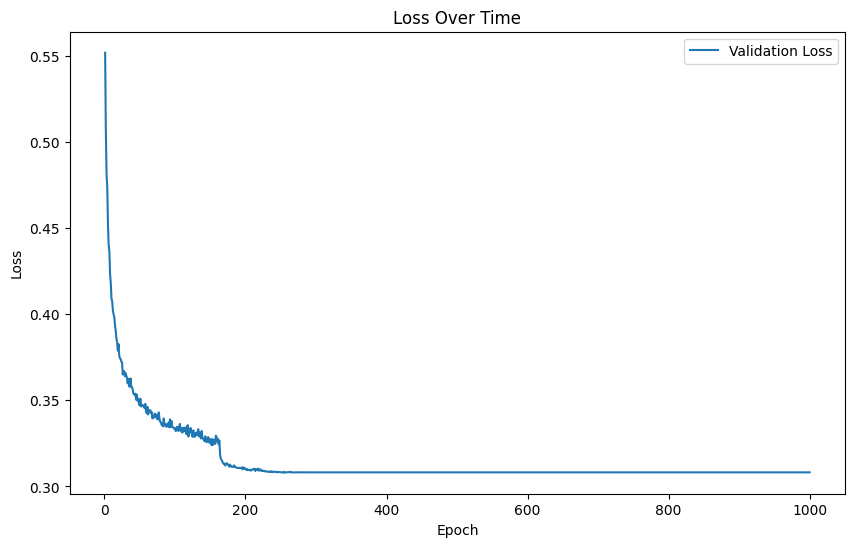

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

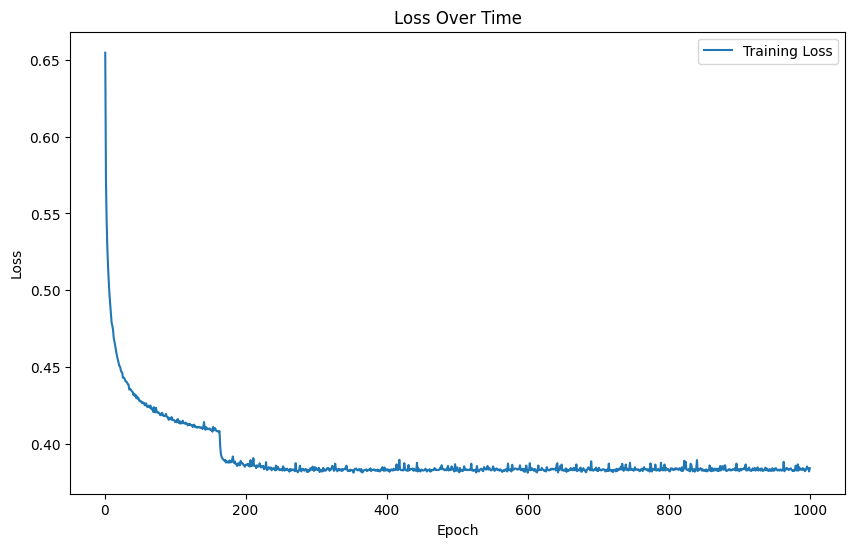

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

## Evaluation on Test Dataset

In [ ]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)

        true_labels.append(y_batch.cpu().numpy())
        pred_labels.append(preds.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

true_labels = np.argmax(true_labels, axis=1)

In [ ]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86     21184
           1       0.87      0.92      0.89     28331
           2       0.83      0.91      0.87      3575
           3       0.86      0.76      0.80       275
           4       0.83      0.60      0.70       949
           5       0.80      0.67      0.73      1737
           6       0.92      0.87      0.89      2051

    accuracy                           0.87     58102
   macro avg       0.86      0.79      0.82     58102
weighted avg       0.87      0.87      0.87     58102

